In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive')

**Data files if you need them**


*   B058 blue coadded spectrum: https://drive.google.com/file/d/1PjUxRuOCIIiZknhQA3ubLnYStqDGaE4y/view?usp=sharing
*B058 blue unflexed coadded spectrum: https://drive.google.com/file/d/1iSRpt5Wya-6bzcuYSX0ywlj-mx8g46FW/view?usp=sharing
*B058 template spectrum: https://drive.google.com/file/d/1Ja4j7Czf6TDaj6bUYpJcKVICc2Gyi6cD/view?usp=sharing
*B058 1D spectrum: https://drive.google.com/file/d/1R1TwDsDzw-4JPGz2Ozdx9DKguRcNzAPh/view?usp=sharing
*   B058 red coadded spectrum: https://drive.google.com/file/d/1vNOZLFeNbtF9EKMI5LXZeEBFvEpZxPek/view?usp=sharing
*Telluric grid: https://drive.google.com/file/d/10eJfwxxFE1BNvRpYGqVwQjo34Wi4zNeD/view?usp=sharing
*Model sky: https://drive.google.com/file/d/155PibNjEVjHTQqg19sX65-iJvzzrfHlA/view?usp=sharing



In [3]:
!pip install astro-sedpy
!pip install astro-prospector
!pip install specutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import astropy.io.fits as fits
import astropy.io.ascii
from astropy.convolution import interpolate_replace_nans, Gaussian1DKernel, convolve, convolve_fft
from sedpy.observate import air2vac
from prospect import utils
from scipy.interpolate import interp1d
import scipy.optimize as op
from scipy.stats import chisquare
from read_alf import Alf
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.nddata import StdDevUncertainty, InverseVariance
from astropy.modeling import models
from scipy.optimize import curve_fit
from specutils.analysis import centroid
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from numpy.fft import fft, ifft, fftfreq, rfftfreq


font = {'family':'serif',
        'weight':'normal',
        'size':20
}
plt.rc('font',**font)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #Polyfit spits out a bunch of warnings (RankWarning: Polyfit may be poorly conditioned), use this to suppress

In [5]:
#Continuum-normalization functions (also normalizes noise)
def data_ranges(lambda_min, lambda_max, flux, wavelength, noise):
    """Return the data within the desired wavelength range.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range 
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength : tuple
        The wavelength data
    noise : tuple
        The noise data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_inrange : tuple
        The flux data within the desired wavelength range
    noise_inrange : tuple
        The noise data within the desired wavelength range
    """
    
    rng = (wavelength >= lambda_min) & (wavelength <= lambda_max)
    wavelength_inrange = wavelength[rng]
    flux_inrange = flux[rng]
    noise_inrange = noise[rng]
    return wavelength_inrange, flux_inrange, noise_inrange

def poly_order(lambda_min, lambda_max):
    """Return the order of the polynomial by which to continuum-normalize the spectrum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
        
    Returns
    -------
    (lambda_min/lambda_max)/100 : int
        The order of the polynomial by which to continuum-normalize the spectrum
    """
    
    return int((lambda_max - lambda_min)/100)

def continuum_normalize(lambda_min, lambda_max, flux, wavelength, noise):
    """Return the spectrum normalized by the fitted polynomial shape of the continuum.
    
    Parameters
    ----------
    lambda_min : float
        The lower bound of the wavelength range
    lambda_max : float
        The upper bound of the wavelength range
    flux : tuple
        The flux data
    wavelength: tuple
        The wavelength data
    noise : tuple
        The noise data
        
    Returns
    -------
    wavelength_inrange : tuple
        The wavelength data within the desired wavelength range
    flux_norm : tuple
        The continuum-normalized flux within the desired wavelength range
    noise_norm : tuple
        The continuum-normalized noise within the desired wavelength range
    """
    
    #Get the data in the desired wavelength range
    wavelength_inrange, flux_inrange, noise_inrange = data_ranges(lambda_min, lambda_max, flux, wavelength, noise)
    
    #Get the order of the polynomial 
    n = poly_order(lambda_min, lambda_max)
    
    #Fit an nth-order polynomial to the spectrum
    xrange = np.linspace(np.min(lambda_min), np.max(lambda_max), len(wavelength_inrange))
    polynomial_fit = np.polyfit(xrange, flux_inrange, n)
    poly_obj = np.poly1d(polynomial_fit)
    
    #Divide out the fitted polynomial to get a continuum-normalized spectrum
    flux_norm = flux_inrange/poly_obj(xrange)
    noise_norm = 1/np.sqrt(noise_inrange)/poly_obj(xrange)
    return wavelength_inrange, flux_norm, noise_norm

def lris_res(lb, lr):
    """Get wavelength dependent resolution.
    
    Parameters
    ----------
    lb, lr : Arrays of blue and red wavelengths in angstroms in vacuum.
    
    Returns
    -------
    resb, resr : Resolution in km/s
    """
    
    resb = 3.09 + 0.187*(lb - 5000.)/1000. #res in A
    resb = resb/lb*3.e5 #res in km/s
    l9 = (lr - 9000.)/1000.
    resr = 1.26 - 0.128*l9 + 0.168*l9**2 + 0.1173*l9**3
    resr = resr/lr*3.E5
    
    return resb, resr

In [6]:
#Blue flexure correction functions (maybe put in a class later, but not necessary yet b/c lack of automation)
#Re-jigged specutils functions
def _resample(resample_method):
    """
    Find the user preferred method of resampling the template spectrum to fit
    the observed spectrum.

    Parameters
    ----------
    resample_method: `string`
        The type of resampling to be done on the template spectrum.

    Returns
    -------
    :class:`~specutils.ResamplerBase`
        This is the actual class that will handle the resampling.
    """
    if resample_method == "flux_conserving":
        return FluxConservingResampler()

    if resample_method == "linear_interpolated":
        return LinearInterpolatedResampler()

    if resample_method == "spline_interpolated":
        return SplineInterpolatedResampler()

    return None

def _normalize_for_template_matching(observed_spectrum, template_spectrum):
    """
    Calculate a scale factor to be applied to the template spectrum so the
    total flux in both spectra will be the same.

    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which needs to be normalized in order to be
        compared with the observed spectrum.

    Returns
    -------
    `float`
        A float which will normalize the template spectrum's flux so that it
        can be compared to the observed spectrum.
    """
    num = np.nansum((observed_spectrum.flux*template_spectrum.flux)/
                 (observed_spectrum.uncertainty.array**2))
    denom = np.nansum((template_spectrum.flux/
                    observed_spectrum.uncertainty.array)**2)

    return num/denom

def _chi_square_for_templates(observed_spectrum, template_spectrum, resample_method):
    """
    Resample the template spectrum to match the wavelength of the observed
    spectrum. Then, calculate chi2 on the flux of the two spectra.

    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which will be resampled to match the wavelength
        of the observed spectrum.

    Returns
    -------
    normalized_template_spectrum : :class:`~specutils.Spectrum1D`
        The normalized spectrum template.
    chi2 : `float`
        The chi2 of the flux of the observed spectrum and the flux of the
        normalized template spectrum.
    """
    # Resample template
    fluxc_resample = _resample(resample_method)
    template_obswavelength = fluxc_resample(template_spectrum,
                                            observed_spectrum.spectral_axis)

    # Numerator
    num_right = template_obswavelength.flux.value
    num = observed_spectrum.flux.value - num_right

    # Denominator
    denom = observed_spectrum.uncertainty.array * observed_spectrum.flux.unit

    # Get chi square
    result = (num/denom)**2
    chi2 = np.nansum(result.value)

    # Create normalized template spectrum, which will be returned with
    # corresponding chi2
    normalized_template_spectrum = Spectrum1D(
        spectral_axis=template_spectrum.spectral_axis,
        flux=template_spectrum.flux)

    return normalized_template_spectrum, chi2

def template_redshift(observed_spectrum, template_spectrum, redshift):
    """
    Find the best-fit redshift for template_spectrum to match observed_spectrum using chi2.

    Parameters
    ----------
    observed_spectrum : :class:`~specutils.Spectrum1D`
        The observed spectrum.
    template_spectrum : :class:`~specutils.Spectrum1D`
        The template spectrum, which will have it's redshift calculated.
    redshift : `float`, `int`, `list`, `tuple`, 'numpy.array`
        A scalar or iterable with the redshift values to test.

    Returns
    -------
    final_redshift : `float`
        The best-fit redshift for template_spectrum to match the observed_spectrum.
    redshifted_spectrum: :class:`~specutils.Spectrum1D`
        A new Spectrum1D object which incorporates the template_spectrum with a spectral_axis
        that has been redshifted using the final_redshift.
    chi2_list : `list`
        A list with the chi2 values corresponding to each input redshift value.
    """
    chi2_min = None
    final_redshift = None
    chi2_list = []

    redshift = np.array(redshift).reshape((np.array(redshift).size,))

    # Loop which goes through available redshift values and finds the smallest chi2
    for rs in redshift:

        # Create new redshifted spectrum and run it through the chi2 method
        redshifted_spectrum = Spectrum1D(spectral_axis=template_spectrum.spectral_axis*(1+rs),
                        flux=template_spectrum.flux, uncertainty=template_spectrum.uncertainty,
                                         meta=template_spectrum.meta)
        normalized_spectral_template, chi2 = _chi_square_for_templates(observed_spectrum, redshifted_spectrum, 
                                                                       'flux_conserving')

        chi2_list.append(chi2)

        # Set new chi2_min if suitable replacement is found - added line here b/c not returning final redshifted spectrum
        if not np.isnan(chi2) and (chi2_min is None or chi2 < chi2_min):
            chi2_min = chi2
            final_redshift = rs
            final_spectrum = redshifted_spectrum

    return final_redshift, chi2_min, final_spectrum, chi2_list

def smooth_general(lris_resolution, data_resolution, wave, flux, noise):
    c = 299792.458 #speed of light in km/s
    sigma_aa_desired = lris_resolution/c*wave
    sigma_aa_original = data_resolution
    delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
    smoothed_flux = utils.smoothing.smoothspec(wave, flux, outwave=wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, 
                                               fftsmooth=True)
    smoothed_noise = utils.smoothing.smoothspec(wave, noise, outwave=wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, 
                                                fftsmooth=True)
    return smoothed_flux, smoothed_noise

def prep_data(data_path, spec_type):
    #Import co-added spectrum with no flexure correction
    data_file = fits.open(data_path)
    if spec_type == 'coadd':
        data_wave_full = data_file[1].data['wave']
        data_flux_full = data_file[1].data['flux']
        data_noise_full = data_file[1].data['ivar']
    else:
        data_wave_full = data_file[1].data['OPT_WAVE']
        data_flux_full = data_file[1].data['OPT_COUNTS']
        data_noise_full = data_file[1].data['OPT_COUNTS_IVAR']
    data_file.close()

    #Limit to useful range
    data_cut_wave = data_wave_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]
    data_cut_flux = data_flux_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]
    data_cut_noise = data_noise_full[(data_wave_full >= 4000) & (data_wave_full <= 6800)]

    return data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise

def prep_template(template_path):
    #Import template
    template_file = pd.read_csv(template_path, skiprows=6,  sep='\t|\s+', 
                                names=['wavelength', 'flux', 'noise', 'weight', 'resolution'], index_col=None)
    template_flux = template_file['flux'].values[(template_file['wavelength'].values >= 4000) & \
                                                 (template_file['wavelength'].values <= 6800)]
    template_wave = template_file['wavelength'].values[(template_file['wavelength'].values >= 4000) & \
                                                       (template_file['wavelength'].values <= 6800)]
    template_noise = np.zeros(len(template_wave))
    template_resolution = template_file['resolution'].values[(template_file['wavelength'].values >= 4000) & \
                                                             (template_file['wavelength'].values <= 6800)]

    #Calculate desired resolution for data template (Keck resolution)
    resb_template, resr_template = lris_res(template_wave, np.nan)

    #Smooth the template 
    smoothed_template_flux, smoothed_template_noise = smooth_general(resb_template, template_resolution, template_wave, 
                                                                     template_flux, template_noise)
    return template_wave, smoothed_template_flux, smoothed_template_noise

def test_pre_full(data_path, template_path, z_lit, z_bound, spec_type):
    #Import data
    data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise = prep_data(data_path, 
                                                                                                              spec_type)

    #Import smoothed template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Continuum normalize over whole wavelength range
    norm_data_wave, norm_data_flux, norm_data_noise = continuum_normalize(np.min(data_cut_wave), np.max(data_cut_wave), 
                                                                          data_cut_flux, data_cut_wave, data_cut_noise)
    norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave), 
                                                                                      np.max(template_wave),
                                                                                      smoothed_template_flux, template_wave, 
                                                                                      smoothed_template_noise)

    #Put spectra into Spectrum1D objects
    data_spec = Spectrum1D(spectral_axis=norm_data_wave*u.Angstrom, flux=norm_data_flux*(u.erg/u.s/u.cm**2/u.Angstrom),
                           uncertainty=StdDevUncertainty(norm_data_noise))
    template_spec = Spectrum1D(spectral_axis=norm_template_wave*u.Angstrom, flux=norm_template_flux*(u.Lsun/u.micron))

    #Plot before
    plt.figure(figsize=(12,4))
    plt.plot(data_spec.spectral_axis, data_spec.flux, label='observed')
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.legend()
    plt.show()

    redshifts = np.linspace(z_lit-z_bound, z_lit+z_bound, 1000)
    tm_result = template_redshift(observed_spectrum=data_spec, template_spectrum=template_spec, redshift=redshifts)

    #Plot after
    plt.figure(figsize=(12,4))
    plt.plot(data_spec.spectral_axis, data_spec.flux, label='observed')
    plt.plot(tm_result[2].spectral_axis, tm_result[2].flux, label='redshifted template')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.plot(tm_result[2].spectral_axis, tm_result[2].flux, label='redshifted template')
    plt.legend()
    plt.show()
    return tm_result[0], tm_result[1]

def data_chunks(data_wave, data_flux, data_noise, targ_delta):
    #Chunk data
    #Turn arrays into lists
    wave_arr = list(data_wave)
    flux_arr = list(data_flux)
    noise_arr = list(data_noise)

    wave_chunks = []
    flux_chunks = []
    noise_chunks = []

    #Initialize counters
    i = wave_arr[0]
    k = 0
    for elem in wave_arr:
        elem_delta = elem - i
        if elem_delta >= targ_delta: #If difference is 220A
            end_ind = wave_arr.index(elem) + 1 #Find ending index
            wave_chunks.append(np.array(wave_arr[k:end_ind])) #Append appropriate values
            flux_chunks.append(np.array(flux_arr[k:end_ind]))
            noise_chunks.append(np.array(noise_arr[k:end_ind]))

            #Re-initialize counters
            i = wave_arr[end_ind]
            k = end_ind
    else: #Get the end of the arrays that won't be 220A wide
        wave_chunks.append(np.array(wave_arr[k:]))
        flux_chunks.append(np.array(flux_arr[k:]))
        noise_chunks.append(np.array(noise_arr[k:]))

    #Normalize chunks
    normed_data = []
    norm_wave_chunks = []
    norm_flux_chunks = []
    norm_noise_chunks = []
    for i in range(len(wave_chunks)):
        normed_data.append(continuum_normalize(np.min(wave_chunks[i]), np.max(wave_chunks[i]), flux_chunks[i], wave_chunks[i], 
                                               noise_chunks[i]))
        norm_wave_chunks.append(normed_data[i][0])
        norm_flux_chunks.append(normed_data[i][1])
        norm_noise_chunks.append(normed_data[i][2])

    return norm_wave_chunks, norm_flux_chunks, norm_noise_chunks

def template_chunks(data_wave, data_flux, data_noise, template_path, z_lit, targ_delta, overhang, position):
    #Import smoothed template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Get data chunks
    data_wave_chunks, data_flux_chunks, data_noise_chunks = data_chunks(data_wave, data_flux, data_noise, targ_delta)

    #Chunk template
    #Find the central wavelength in each bin
    central_wavelengths = np.zeros(len(data_wave_chunks))
    for i in range(len(data_wave_chunks)):
        central_wavelengths[i] = np.median(data_wave_chunks[i])

    if position == 'before':
        dered_central_wavelengths = central_wavelengths/(1+z_lit)
    else:
        dered_central_wavelengths = central_wavelengths

    #Get the bounds of the template chunks (with overhang)
    template_wave_bounds = []
    for i in range(len(data_wave_chunks)):
        template_wave_bounds.append([dered_central_wavelengths[i] - (np.max(data_wave_chunks[i]) - \
                                                               np.min(data_wave_chunks[i]))/2  - overhang, 
                                     dered_central_wavelengths[i] + (np.max(data_wave_chunks[i]) - \
                                                               np.min(data_wave_chunks[i]))/2 + overhang])

    #Chunk the template based on these bounds
    template_wave_chunks = []
    template_flux_chunks = []
    template_noise_chunks = []
    for i in range(len(template_wave_bounds)):
        template_wave_chunks.append(template_wave[(template_wave >= template_wave_bounds[i][0]) & \
                                                  (template_wave <= template_wave_bounds[i][-1])])
        template_flux_chunks.append(smoothed_template_flux[(template_wave >= template_wave_bounds[i][0]) & \
                                                  (template_wave <= template_wave_bounds[i][-1])])
        template_noise_chunks.append(np.zeros(len(template_wave_chunks[i])))

    #Normalize the template chunks
    normed_template_data = []
    norm_temp_wave_chunks = []
    norm_temp_flux_chunks = []
    norm_temp_noise_chunks = []
    for i in range(len(template_wave_chunks)):
        normed_template_data.append(continuum_normalize(np.min(template_wave_chunks[i]), np.max(template_wave_chunks[i]), 
                                                        template_flux_chunks[i], template_wave_chunks[i], 
                                                        template_noise_chunks[i]))
        norm_temp_wave_chunks.append(normed_template_data[i][0])
        norm_temp_flux_chunks.append(normed_template_data[i][1])
        norm_temp_noise_chunks.append(normed_template_data[i][2])

    #Get centre of each template chunk and redshift it
    temp_central_wavelengths = np.zeros(len(norm_temp_wave_chunks))
    for i in range(len(norm_temp_wave_chunks)):
        temp_central_wavelengths[i] = np.median(norm_temp_wave_chunks[i])*(1+z_lit)

    return norm_temp_wave_chunks, norm_temp_flux_chunks, norm_temp_noise_chunks, temp_central_wavelengths, central_wavelengths

def QA_chunks(data_wave_chunks, data_flux_chunks, temp_wave_chunks, temp_flux_chunks):
    #Plot
    for i in range(len(data_wave_chunks)):
        plt.figure()
        plt.plot(data_wave_chunks[i], data_flux_chunks[i], label='observed')
        plt.plot(temp_wave_chunks[i], temp_flux_chunks[i], label='template')
        plt.legend()

def chunk_redshift(data_wave, data_flux, data_noise, template_path, z_lit, targ_delta, overhang, z_test, z_bound, position):
    #Get data chunks
    data_wave_chunks, data_flux_chunks, data_noise_chunks = data_chunks(data_wave, data_flux, data_noise, targ_delta)

    #Get template_chunks 
    temp_wave_chunks, temp_flux_chunks, temp_noise_chunks, temp_central_wavelengths, central_waves = template_chunks(data_wave, 
                                                                                                                     data_flux,
                                                                                                      data_noise, template_path,
                                                                                                      z_lit, targ_delta,
                                                                                                      overhang, position)

    #Find redshifts of each chunk
    observed_chunks = []
    temp_chunks = []
    for i in range(len(data_wave_chunks)):
        observed_chunks.append(Spectrum1D(spectral_axis=data_wave_chunks[i]*u.Angstrom, 
                                          flux=data_flux_chunks[i]*(u.erg/u.s/u.cm**2/u.Angstrom), 
                                          uncertainty=InverseVariance(data_noise_chunks[i])))
        temp_chunks.append(Spectrum1D(spectral_axis=temp_wave_chunks[i]*u.Angstrom, 
                                 flux=temp_flux_chunks[i]*(u.Lsun/u.micron),
                                 uncertainty=StdDevUncertainty(temp_noise_chunks[i])))

    redshifts_chunks = np.linspace(z_test-z_bound, z_test+z_bound, 1000)
    fitted_redshift_results = []
    bestfit_redshift = np.zeros(len(data_wave_chunks))
    best_chi2 = np.zeros(len(data_wave_chunks))
    redshifted_spectra = []
    chi2 = []
    for i in range(len(data_wave_chunks)):
        fitted_redshift_results.append(template_redshift(observed_spectrum=observed_chunks[i], 
                                                            template_spectrum=temp_chunks[i],
                                                            redshift=redshifts_chunks))
        bestfit_redshift[i] = fitted_redshift_results[i][0]
        best_chi2[i] = fitted_redshift_results[i][1]
        redshifted_spectra.append(fitted_redshift_results[i][2])
        chi2.append(fitted_redshift_results[i][3])
    return bestfit_redshift, best_chi2, redshifted_spectra, chi2

def fit_errors(bestfit_redshift, central_wavelengths):
    c = 299792.458 #speed of light in km/s
    #Calculate errors in Angstroms
    errors_A = bestfit_redshift*central_wavelengths 

    #Fit a straight line to the errors
    fit = np.polyfit(central_wavelengths, errors_A, 1)
    fit_z = np.polyfit(central_wavelengths, bestfit_redshift, 1)
    fit_kms = np.polyfit(central_wavelengths, errors_A/central_wavelengths*c, 1)

    error_func = np.poly1d(fit)
    error_func_z = np.poly1d(fit_z)
    error_func_kms = np.poly1d(fit_kms)
    return fit, fit_z, fit_kms, error_func, error_func_z, error_func_kms, errors_A

def QA_fit(bestfit_redshift, central_wavelengths):
    fit, fit_z, fit_kms, error_func, error_func_z, error_func_kms, errors_A = fit_errors(bestfit_redshift, central_wavelengths)

    c = 299792.458 #speed of light in km/s
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.set_tight_layout(True)
    #Plot in z
    ax[0].plot(central_wavelengths, bestfit_redshift, linestyle='None', marker='.', markersize=30, mew=2, mec='w', color='k',
               alpha=0.8)
    ax[0].plot(central_wavelengths, error_func_z(central_wavelengths), color='k')
    ax[0].tick_params(length=6, width=2, labelsize=12)
    ax[0].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[0].set_ylabel('Error (z)', fontsize=15)

    #Plot in Angstroms
    ax[1].plot(central_wavelengths, errors_A, linestyle='None', marker='.', markersize=30, mew=2, mec='w', color='k', alpha=0.8)
    ax[1].plot(central_wavelengths, error_func(central_wavelengths), color='k')
    ax[1].tick_params(length=6, width=2, labelsize=12)
    ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[1].set_ylabel('Error ($\Delta\AA$)', fontsize=15)

    #Plot in km/s
    ax[2].plot(central_wavelengths, errors_A/central_wavelengths*c, linestyle='None', marker='.', markersize=30, mew=2, mec='w',
               color='k', alpha=0.8)
    ax[2].plot(central_wavelengths, error_func_kms(central_wavelengths), color='k')
    ax[2].tick_params(length=6, width=2, labelsize=12)
    ax[2].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[2].set_ylabel('Error ($\Delta$ km/s)', fontsize=15)

def flexure_function(fit, z_lit, wave):
    #Solve coefficients
    c = fit[0]
    d = fit[1]

    a = d
    b = (c - z_lit)/(1+z_lit)

    corr_factor = (b*wave + a)/(1 + b)
    wave_corr = wave - corr_factor

    #Check if monotonic
    print('Montonic: ', np.all(np.diff(wave_corr) > 0))
    return corr_factor, wave_corr, a, b

def flexure_QA(wave, wave_corr):
    plt.figure(figsize=(8,7))
    plt.plot(wave, label='original', lw=3)
    plt.plot(wave_corr, label='corrected', linestyle='dashed')
    plt.legend()
    plt.ylabel('Wavelength ($\AA$)')
    plt.xlabel('Pixel')

def dered_corr(data_path, template_path, wave_corr, z_lit, z_bound, spec_type):
    #Get data
    data_wave_full, data_cut_wave, data_flux_full, data_cut_flux, data_noise_full, data_cut_noise = prep_data(data_path,
                                                                                                             spec_type)

    #Get template
    template_wave, smoothed_template_flux, smoothed_template_noise = prep_template(template_path)

    #Find redshift of new, corrected spectrum and de-redshift it to match the template
    #Continuum-norm over whole blue range
    norm_wave_corr, norm_corr_flux, norm_corr_noise = continuum_normalize(np.min(wave_corr), np.max(wave_corr), data_cut_flux, 
                                                                          wave_corr, data_cut_noise)
    norm_template_wave, norm_template_flux, norm_template_noise = continuum_normalize(np.min(template_wave), 
                                                                                      np.max(template_wave), 
                                                                                      smoothed_template_flux, template_wave, 
                                                                                      smoothed_template_noise)

    #Plot before
    plt.figure(figsize=(12,4))
    plt.plot(norm_wave_corr, norm_corr_flux, label='observed')
    plt.plot(norm_template_wave, norm_template_flux, label='template')
    plt.legend()

    #Find new redshift of whole spectrum
    corr_spec = Spectrum1D(spectral_axis=norm_wave_corr*u.Angstrom, flux=norm_corr_flux*(u.erg/u.s/u.cm**2/u.Angstrom),
                           uncertainty=StdDevUncertainty(norm_corr_noise))
    template_spec = Spectrum1D(spectral_axis=norm_template_wave*u.Angstrom, flux=norm_template_flux*(u.Lsun/u.micron))

    pre_redshifts = np.linspace(z_lit-z_bound, z_lit+z_bound, 1000)
    tm_result_corr = template_redshift(observed_spectrum=corr_spec, template_spectrum=template_spec, redshift=pre_redshifts)

    #Plot after
    plt.figure(figsize=(12,4))
    plt.plot(corr_spec.spectral_axis, corr_spec.flux, label='observed')
    plt.plot(tm_result_corr[2].spectral_axis, tm_result_corr[2].flux, label='redshifted template')
    plt.legend()
    #plt.savefig('debug_after_corr.png', bbox_inches='tight')

    plt.figure(figsize=(12,4))
    plt.plot(template_spec.spectral_axis, template_spec.flux, label='template')
    plt.plot(tm_result_corr[2].spectral_axis, tm_result_corr[2].flux, label='redshifted template')
    plt.legend()

    #De-redshift data
    dered_wave = norm_wave_corr/(1+z_lit)

    plt.figure(figsize=(12,4))
    plt.plot(dered_wave, norm_corr_flux, label='de-redshifted data')
    plt.plot(norm_template_wave, norm_template_flux, label='template')
    plt.legend()
    #plt.savefig('debug_dered.png', bbox_inches='tight')
    return tm_result_corr, dered_wave

In [7]:
#Red flexure correction functions (no class for now)
def read_1dspec(filename):
    file = fits.open(filename)
    data = file[1].data
    file.close()
    
    wave = data['OPT_WAVE']
    sky_flux = data['OPT_COUNTS_SKY']
    return wave, sky_flux

def read_skymod(filename):
    file = fits.open(filename)
    sky_flux = file[0].data
    wave = file[1].data
    file.close()
    return wave, sky_flux
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
        
def gaussian(x, a, x0, sigma, d):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + d

def data_resolution(sky_wave, sky_flux):
    #Find FWHM of 4 lines across the spectrum and take the mean to find the resolution 
    line1 = [5575, 5585]
    line2 = [6300, 6305]
    line3 = [8346, 8348]
    line4 = [9377, 9380]

    line1_wave, line1_flux, line1_noise = continuum_normalize(line1[0], line1[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line1 = len(line1_wave)
    mean_line1 = np.mean(line1_wave)
    std_line1 = np.std(line1_wave)
    popt_line1, pcov_line1 = curve_fit(gaussian, line1_wave, line1_flux, p0=[np.max(line1_flux), mean_line1, std_line1, 0])
    FWHM_line1 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line1[2])

    line2_wave, line2_flux, line2_noise = continuum_normalize(line2[0], line2[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line2 = len(line2_wave)
    mean_line2 = np.mean(line2_wave)
    std_line2 = np.std(line2_wave)
    popt_line2, pcov_line2 = curve_fit(gaussian, line2_wave, line2_flux, p0=[np.max(line2_flux), mean_line2, std_line2, 0])
    FWHM_line2 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line2[2])

    line3_wave, line3_flux, line3_noise = continuum_normalize(line3[0], line3[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line3 = len(line3_wave)
    mean_line3 = np.mean(line3_wave)
    std_line3 = np.std(line3_wave)
    popt_line3, pcov_line3 = curve_fit(gaussian, line3_wave, line3_flux, p0=[np.max(line3_flux), mean_line3, std_line3, 0])
    FWHM_line3 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line3[2])

    line4_wave, line4_flux, line4_noise = continuum_normalize(line4[0], line4[-1], sky_flux, sky_wave, np.zeros_like(sky_flux))
    n_line4 = len(line4_wave)
    mean_line4 = np.mean(line4_wave)
    std_line4 = np.std(line4_wave)
    popt_line4, pcov_line4 = curve_fit(gaussian, line4_wave, line4_flux, p0=[np.max(line4_flux), mean_line4, std_line4, 0])
    FWHM_line4 = 2*np.sqrt(2*np.log(2))*np.abs(popt_line4[2])
    
    R_red = np.mean((FWHM_line1, FWHM_line2, FWHM_line3, FWHM_line4))
    return R_red

def smooth_red(sky_wave, sky_flux):
    desired_blue_res, desired_red_res = lris_res(sky_wave[sky_wave <= 7000], sky_wave[sky_wave > 7000])
    desired_res = np.concatenate((desired_blue_res, desired_red_res))
    c = 299792.458 #speed of light
    
    #Smooth red 
    R_red = data_resolution(sky_wave, sky_flux)
    in_sigma_kms_red = (R_red/sky_wave)*c
    smoothed_sky_flux, smoothed_sky_noise = smooth_general(desired_res, in_sigma_kms_red/c*sky_wave, sky_wave, sky_flux, 
                                                           np.zeros_like(sky_flux))
    return smoothed_sky_flux, smoothed_sky_noise

def sky_centroids(sky_wave, smoothed_sky_flux, smoothed_sky_noise):
    #Normalize sky model
    sky_norm_wave, sky_norm_flux, sky_norm_noise = continuum_normalize(np.min(sky_wave), np.max(sky_wave), smoothed_sky_flux, 
                                                                       sky_wave, smoothed_sky_noise)
    
    #Find centroids of skylines in model
    centroids = [7843, 7916, 7995.5, 8347, 8467, 8829.5, 8922, 9378, 9442, 9794]
    sky_bounds = [[7835, 7850], [7908, 7920], [7990, 8000], [8340, 8353], [8460, 8475], [8820, 8835], [8915, 8930], 
                      [9370, 9385], [9435, 9447], [9785, 9799]]

    sky = Spectrum1D(spectral_axis=sky_norm_wave*u.Angstrom, flux=sky_norm_flux*u.ct)
    regions_sky = []
    for i in range(len(sky_bounds)):
        regions_sky.append(SpectralRegion(sky_bounds[i][0]*u.Angstrom, sky_bounds[i][-1]*u.Angstrom))

    sky_cents = centroid(sky, regions_sky)
    return sky_cents

def centroid_offsets(targ_bounds, data_wave, data_flux, sky_cents):
    regions = SpectralRegion(targ_bounds[0][0]*u.Angstrom,targ_bounds[0][-1]*u.Angstrom)
    for i in range(1, len(targ_bounds)):
        regions += SpectralRegion(targ_bounds[i][0]*u.Angstrom, targ_bounds[i][-1]*u.Angstrom)

    #Normalize data
    targ_norm_wave, targ_norm_flux, targ_norm_noise = continuum_normalize(np.min(data_wave), np.max(data_wave), data_flux, 
                                                                          data_wave, np.zeros(len(data_flux)))
    
    
    #Find offsets
    target = Spectrum1D(spectral_axis=targ_norm_wave*u.Angstrom, flux=targ_norm_flux*u.ct)
    sub_spec = extract_region(target, regions)
    offsets = np.zeros(len(sky_cents))
    nearest_waves = np.zeros(len(sky_cents))
    for i, sub in enumerate(sub_spec):
        an_disp = sub.flux.max()
        an_ampl = sub.flux.min()
        an_mean = sub.spectral_axis[sub.flux.argmax()]
        nearest_waves[i] = an_mean.value
        an_stdv = np.sqrt(np.sum((sub.spectral_axis - an_mean)**2) / (len(sub.spectral_axis) - 1))

        plt.figure()
        plt.scatter(an_mean.value, an_disp.value, marker='o', color='#e41a1c', s=100, label='data')
        plt.scatter(sky_cents[i], an_disp.value, marker='o', color='k', s=100, label='archive')
        plt.vlines([an_mean.value - an_stdv.value, an_mean.value + an_stdv.value],
                    sub.flux.min().value, sub.flux.max().value,
                    color='#377eb8', ls='--', lw=2)
        g_init = ( models.Const1D(an_disp) +
                  models.Gaussian1D(amplitude=(an_ampl - an_disp),
                                mean=an_mean, stddev=an_stdv) )
        g_fit = fit_lines(sub, g_init)
        line_fit = g_fit(sub.spectral_axis)
        plt.plot(sub.spectral_axis, sub.flux, color='#e41a1c', lw=2)
        plt.plot(sub.spectral_axis, line_fit, color='#377eb8', lw=2)

        plt.axvline(an_mean.value, color='#e41a1c', ls='--', lw=2)
        plt.legend()
        offsets[i] = an_mean.value - sky_cents[i].value
    return nearest_waves, offsets

def offset_fit(nearest_waves, offsets):
    c = 299792.458 #speed of light
    fit = np.polyfit(nearest_waves, offsets, 1)
    fit_kms = np.polyfit(nearest_waves, offsets/nearest_waves*c, 1)

    fit_func = np.poly1d(fit)
    fit_func_kms = np.poly1d(fit_kms)
    return fit, fit_kms, fit_func, fit_func_kms

def QA_offset_fit(nearest_waves, offsets):
    fit, fit_kms, fit_func, fit_func_kms = offset_fit(nearest_waves, offsets)
    c = 299792.458 #speed of light
    
    #Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    fig.set_tight_layout(True)
    
    #In Angstroms
    ax[0].plot(nearest_waves, offsets, linestyle='None', marker='.', markersize=30, mew=2, mec='w', alpha=0.8, color='k')
    ax[0].plot(nearest_waves, fit_func(nearest_waves), color='k', alpha=0.8)
    ax[0].tick_params(length=6, width=2, labelsize=12)
    ax[0].set_xlabel('Wavelength ($\AA$)', fontsize=15)
    ax[0].set_ylabel('Error ($\AA$)', fontsize=15)
    
    #In km/s
    ax[1].plot(nearest_waves, offsets/nearest_waves*c, linestyle='None', marker='.', markersize=30, mew=2, mec='w', 
             alpha=0.8, color='k')
    ax[1].plot(nearest_waves, fit_func_kms(nearest_waves), color='k', alpha=0.8)
    ax[1].tick_params(length=6, width=2, labelsize=12)
    ax[1].set_xlabel('Wavelength ($\AA$)', fontsize=20)
    ax[1].set_ylabel('Error (km/s)', fontsize=20)
    
def fit_interp(data_wave, data_flux, data_noise, nearest_waves, fit_func):
    
    #Interpolate fits over wavelength range
    error_func = interp1d(nearest_waves, fit_func(nearest_waves), fill_value='extrapolate')
    corr_factor = error_func(data_wave)
    
    #Add correction factor to wavelength array
    wave_corr = data_wave - corr_factor
    
    #Make sure new wavelength arrays are monotonically increasing
    plt.figure(figsize=(8,7))
    plt.plot(data_wave, label='original', lw=3)
    plt.plot(wave_corr, label='corrected', linestyle='dashed')
    plt.xlabel('Pixel')
    plt.legend()
    plt.ylabel('Wavelength ($\AA$)')

    print('Monotonic: ', np.all(np.diff(wave_corr) > 0))
    return wave_corr

In [8]:
#Telluric correction functions
#Alexa's wavelength-dependent resolution function
def lris_res(lb, lr):
    """Get wavelength dependent resolution.
    
    Parameters
    ----------
    lb, lr : Arrays of blue and red wavelengths in angstroms in vacuum.
    
    Returns
    -------
    resb, resr : Resolution in km/s
    """
    
    resb = 3.09 + 0.187*(lb - 5000.)/1000. #res in A
    resb = resb/lb*3.e5 #res in km/s
    l9 = (lr - 9000.)/1000.
    resr = 1.26 - 0.128*l9 + 0.168*l9**2 + 0.1173*l9**3
    resr = resr/lr*3.E5
    
    return resb, resr
    
    
def normalize(wavelength, flux):
    """Return a normalized spectrum using a 4th-order polynomial (used old continuum-normalization code
    as a model).
    
    Parameters
    ----------
    wavelength : tuple
        Wavelength array
    flux : tuple
        Flux array
        
    Returns
    -------
    flux_norm : tuple
        Normalized flux
    """
    
    #Fit a 4th-order polynomial to the spectrum
    lambda_min = np.min(wavelength)
    lambda_max = np.min(wavelength)
    xrange = np.linspace(np.min(lambda_min), np.max(lambda_max), len(wavelength))
    polynomial_fit = np.polyfit(xrange, flux, 4)
    poly_obj = np.poly1d(polynomial_fit)
    
    #Divide out the fitted polynomial to get a continuum-normalized spectrum
    flux_norm = flux/poly_obj(xrange)
    
    return flux_norm
    
    
def minimization(f, correction_template_flux, correction_gal_flux):
	"""Minimization for scipy.optimize.minimize to find the scale factor between the template and target spectra.
	
	Parameters
	----------
	f : float
		Initial guess for scale factor
	correction_template_flux : tuple
		Flux array over minimization range for the template
	correction_gal_flux : tuple
		Flux array over minimization range for target
		
	Returns
	-------
	np.max(np.abs(correction_gal_flux - Tf)) : float
		The maximum absolute difference between the target flux and scaled template flux
	"""
	
	#Scale the template flux 
	Tf = 1 + f*(correction_template_flux - 1)
	
	#Minimize
	return np.max(np.abs(correction_gal_flux - Tf))
    
    
def Tf(f, T0):
    """Return the scaled template spectrum.
    
    Parameters
    ----------
    f : float
        Scale parameter
    T0 : tuple
        Template atmospheric transmission spectrum
    
    Returns
    -------
    1 + f*(T0 - 1) : tuple
        Scaled template spectrum
    """
    
    return 1 + f*(T0 - 1)

def telluric_correction(blue_path, red_path, template_wave, template_flux, target_blue_wave, target_red_wave):
    """Return the tellurically-corrected flux and corresponding wavelength for a reduced object.

    Parameters
    ----------
    blue_path : str
        Path to the blue coadded spectrum
    red_path : str
        Path to the red coadded spectrum

    Returns
    -------
    total_target_wave : tuple
        Wavelength array
    telluric_corrected_flux : tuple
        Tellurically-corrected flux array
    """

    #Import co-added target spectra
    blue_coadd1d = fits.open(blue_path)
    blue_dat = blue_coadd1d[1].data
    blue_coadd1d.close()

    red_coadd1d = fits.open(red_path)
    red_dat = red_coadd1d[1].data
    red_coadd1d.close()

    #Get wavelengths and fluxes for target and template
    #target_blue_wave = blue_dat['wave']
    #target_red_wave = red_dat['wave']
    target_blue_flux = blue_dat['flux']
    target_red_flux = red_dat['flux']
    target_blue_ivar = blue_dat['ivar']
    target_red_ivar = red_dat['ivar']
    target_noise = 1/np.sqrt(np.concatenate((target_blue_ivar, target_red_ivar)))

    template_blue_wave = template_wave[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_wave = template_wave[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]
    template_blue_flux = template_flux[(template_wave >= np.min(target_blue_wave)) & (template_wave <= np.max(target_blue_wave))]
    template_red_flux = template_flux[(template_wave >= np.min(target_red_wave)) & (template_wave <= np.max(target_red_wave))]

    #Get resolution using wavelength ranges from target object
    resb_template, resr_template = lris_res(template_blue_wave, template_red_wave)

    #Concatenate into one wavelength range
    total_template_res = np.concatenate((resb_template, resr_template))
    total_template_wave = np.concatenate((template_blue_wave, template_red_wave))
    total_template_flux = np.concatenate((template_blue_flux, template_red_flux))
    total_target_wave = np.concatenate((target_blue_wave, target_red_wave))
    total_target_flux = np.concatenate((target_blue_flux, target_red_flux))

    #Convert telluric resolution to km/s
    c = 299792.458 #speed of light
    R = 20000 #instrument resolution
    inval = total_template_wave/R
    in_sigma = inval/2.*np.sqrt(2.*np.log(2))
    in_sigma_kms = (in_sigma/total_template_wave)*c

    #Smooth template spectrum
    sigma_aa_desired = total_template_res/c*total_template_wave
    sigma_aa_original = in_sigma_kms/c*total_template_wave
    delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
    smoothed_template_flux = utils.smoothing.smoothspec(total_template_wave, total_template_flux, outwave=total_template_wave, smoothtype='lsf', resolution=delta_sigma_aa_vector, fftsmooth=True)

    #Re-grid template spectrum by interpolating onto target wavelength grid
    regrid_template_flux = np.interp(total_target_wave, total_template_wave, smoothed_template_flux)

    #Normalize the target and template spectra over 9250-9650A
    normrange_wave = total_target_wave[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_target_flux = total_target_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normrange_template_flux = regrid_template_flux[(total_target_wave >= 9250) & (total_target_wave <= 9650)]
    normed_template_flux = normalize(normrange_wave, normrange_template_flux)
    normed_target_flux = normalize(normrange_wave, normrange_target_flux)

    #Do the minimization over 9320-9380A
    correction_wave = normrange_wave[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_template_flux = normed_template_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]
    correction_target_flux = normed_target_flux[(normrange_wave >= 9320) & (normrange_wave <= 9380)]

    x0 = 1 #Initial guess
    res = op.minimize(minimization, x0, args=(correction_template_flux, correction_target_flux), method='Nelder-Mead', tol=1e-6)
    #print(res)

    #Get the chi-squared value for the fit
    corrected_template_flux = Tf(res.x, correction_template_flux)
    residuals = ((correction_target_flux - corrected_template_flux)/correction_target_flux)*100
    cdist = np.sort(residuals)
    chisq_val, p_val = chisquare(cdist)

    #Scale the template spectrum by the best-fit scale factor 
    scaled_template_flux = Tf(res.x, regrid_template_flux)

    return total_target_wave, scaled_template_flux, chisq_val, total_target_flux

def best_template(blue_path, red_path, template_wave, template_fluxes, target_blue_wave, target_red_wave):
    scaled_dat = []
    for i in range(len(template_fluxes)):
        for j in range(len(template_fluxes[i])):
            for k in range(len(template_fluxes[i][j])):
                for l in range(len(template_fluxes[i][j][k])):
                    scaled_dat.append(telluric_correction(blue_path, red_path, template_wave, 
                                                          template_fluxes[i][j][k][l], target_blue_wave, target_red_wave))
    scaled_dat = np.array(scaled_dat)
    scaled_wave = scaled_dat[:,0]
    scaled_flux = scaled_dat[:,1]
    chisquares = scaled_dat[:,2]
    target_flux = scaled_dat[:,3]
    
    best_scaled_template = scaled_flux[np.argmin(chisquares)]
    tell_flux = target_flux[np.argmin(chisquares)]/best_scaled_template
    tell_wave = scaled_wave[np.argmin(chisquares)]
    targ_flux = target_flux[np.argmin(chisquares)]
    return best_scaled_template, tell_flux, tell_wave, targ_flux

#Tellurically-correct new spectra
def telluric_correction_routine(blue_path, red_path, target_blue_wave, target_red_wave):
    #Import telluric grid
    file = '/content/gdrive/My Drive/TelFit_MaunaKea_3100_26100_R20000.fits'
    hdul = fits.open(file)
    header0 = hdul[0].header
    data0 = hdul[0].data #flux
    header1 = hdul[1].header
    data1 = hdul[1].data #wavelength
    hdul.close()
    template_wave = data1*10 #Convert from nm to A
    template_fluxes = data0
                    
    #Scale the template spectra
    scaled_template, tell_flux, tell_wave, targ_flux = best_template(blue_path, red_path, template_wave, template_fluxes, target_blue_wave, target_red_wave)
    return tell_flux, tell_wave, scaled_template, targ_flux

# Flexure correction
## Blue

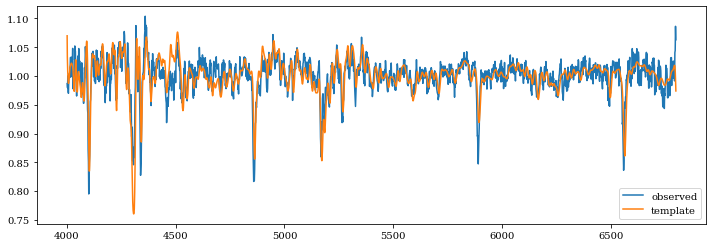

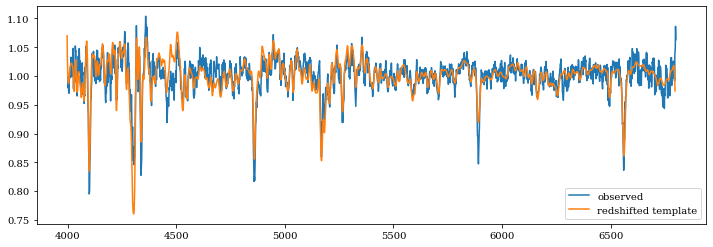

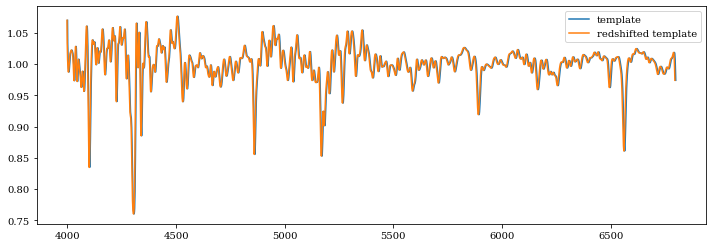

-0.0005858448448448454 8842.410711443112


In [9]:
#Blue flexure
B058_flex_path = '/content/gdrive/My Drive/B058_blue_coadd1d.fits'
B058_template_path = '/content/gdrive/My Drive/mock_b058_old_template.dat'

#Test finding redshift of entire spectrum
B058_z_lit = -0.000741
B058_test_z, B058_test_chi = test_pre_full(B058_flex_path, B058_template_path, B058_z_lit, 0.005, 'coadd')
print(B058_test_z, B058_test_chi)

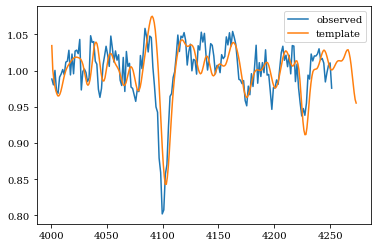

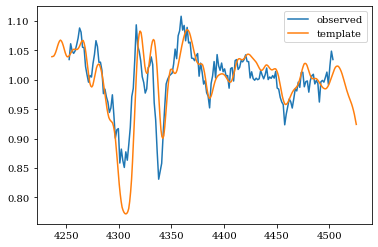

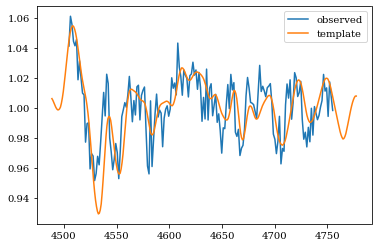

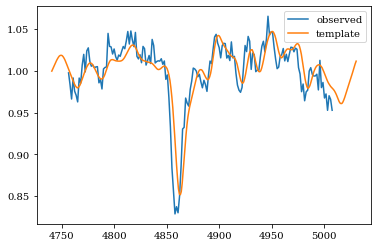

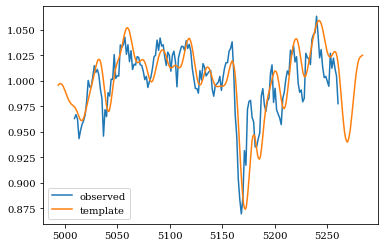

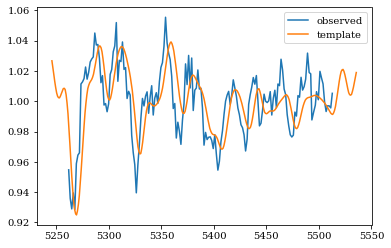

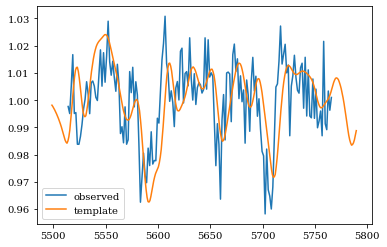

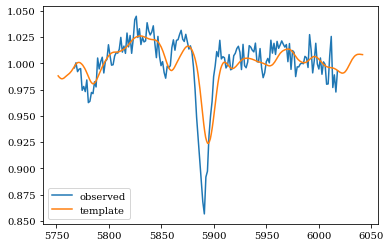

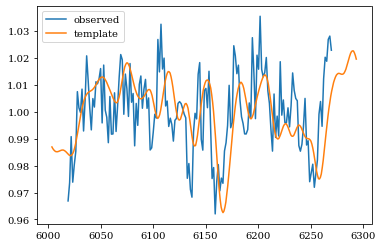

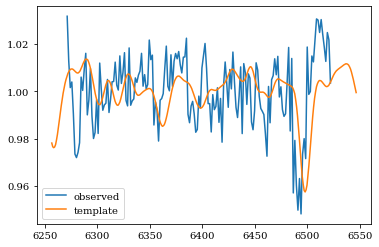

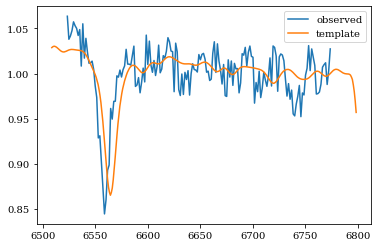

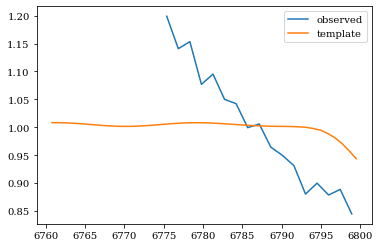

In [10]:
#Measure redshift in chunks
B058_noflex_path = '/content/gdrive/My Drive/B058_noflex_blue_coadd1d.fits'
B058_wave_full, B058_cut_wave, B058_flux_full, B058_cut_flux, B058_noise_full, B058_cut_noise = prep_data(B058_noflex_path, 'coadd')
B058_norm_blue_wave_chunks, B058_norm_blue_flux_chunks, B058_norm_blue_noise_chunks = data_chunks(B058_cut_wave, B058_cut_flux, B058_cut_noise, 250)
B058_norm_template_wave_chunks, B058_norm_template_flux_chunks, B058_norm_template_noise_chunks, B058_template_central_wavelengths, B058_central_wavelengths = \
template_chunks(B058_cut_wave, B058_cut_flux, B058_cut_noise, B058_template_path, B058_z_lit, 250, 20, 'before')
QA_chunks(B058_norm_blue_wave_chunks, B058_norm_blue_flux_chunks, B058_norm_template_wave_chunks, B058_norm_template_flux_chunks)

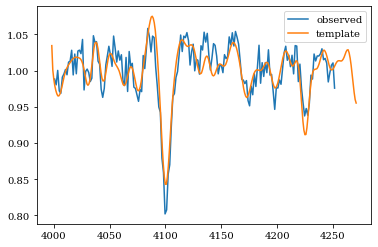

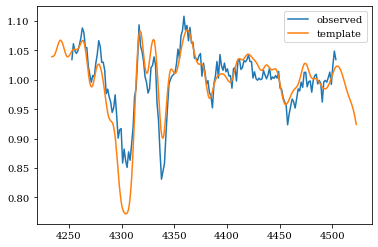

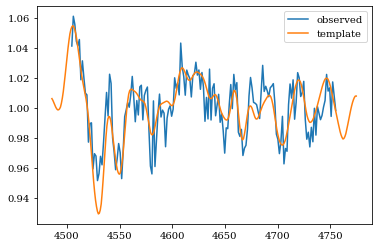

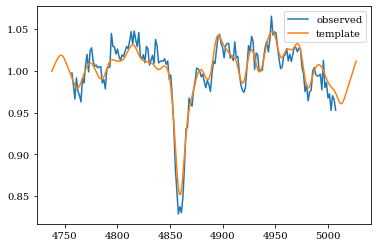

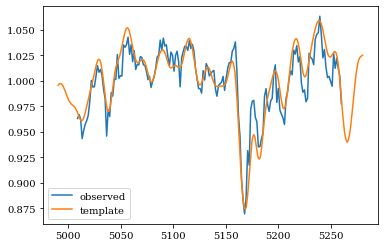

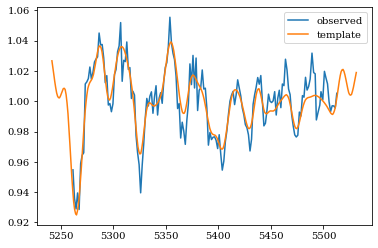

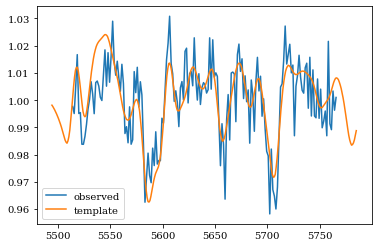

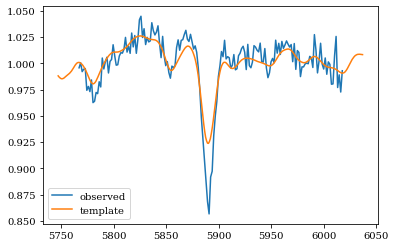

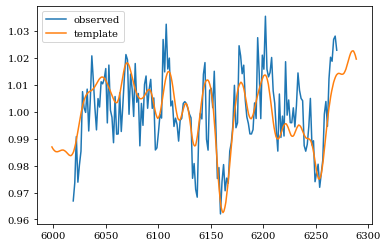

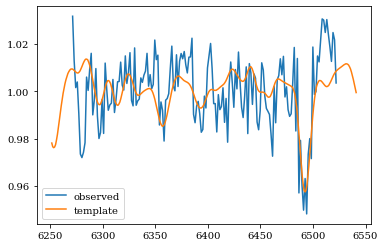

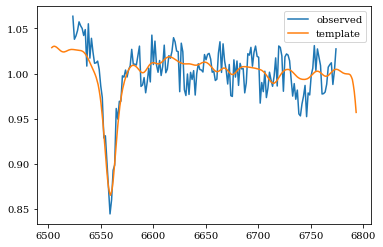

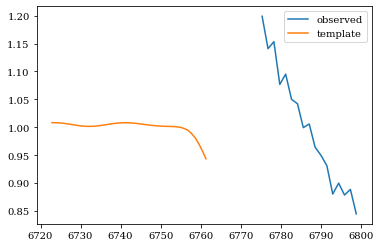

In [11]:
B058_bestfit_redshift, B058_best_chi2, B058_redshifted_spectra, B058_chi2 = chunk_redshift(B058_cut_wave, B058_cut_flux, B058_cut_noise, B058_template_path, 
                                                                                           B058_z_lit, 250, 20, -0.00061, 0.005, 'before')
B058_redshifted_waves = []
B058_redshifted_fluxes = []
for i in range(len(B058_redshifted_spectra)):
    B058_redshifted_waves.append(B058_redshifted_spectra[i].spectral_axis)
    B058_redshifted_fluxes.append(B058_redshifted_spectra[i].flux)
QA_chunks(B058_norm_blue_wave_chunks, B058_norm_blue_flux_chunks, B058_redshifted_waves, B058_redshifted_fluxes)

Montonic:  True


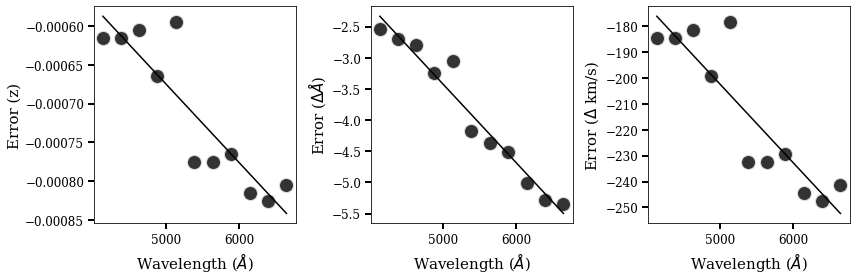

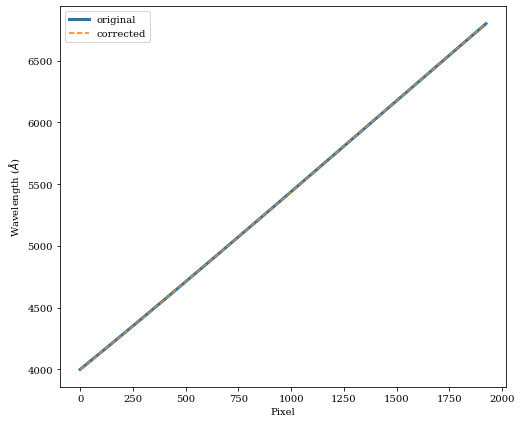

In [12]:
B058_blue_fit, B058_blue_fit_z, B058_blue_fit_kms, B058_blue_error_func, B058_blue_error_func_z, B058_blue_error_func_kms, B058_blue_errors_A = \
fit_errors(B058_bestfit_redshift[:-1], B058_template_central_wavelengths[:-1])
QA_fit(B058_bestfit_redshift[:-1], B058_template_central_wavelengths[:-1])
B058_blue_corr_factor, B058_blue_wave_corr, B058_a, B058_b = flexure_function(B058_blue_fit, B058_z_lit, B058_cut_wave)
flexure_QA(B058_cut_wave, B058_blue_wave_corr)

-0.0007259849849849858


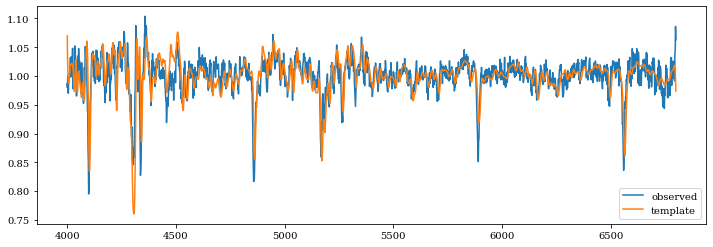

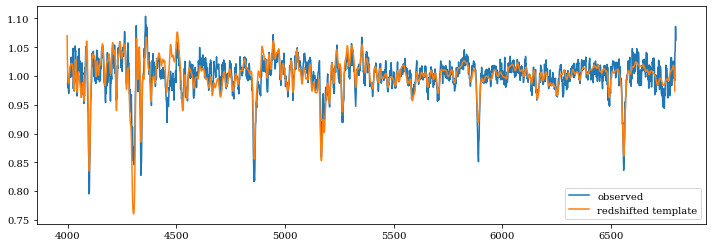

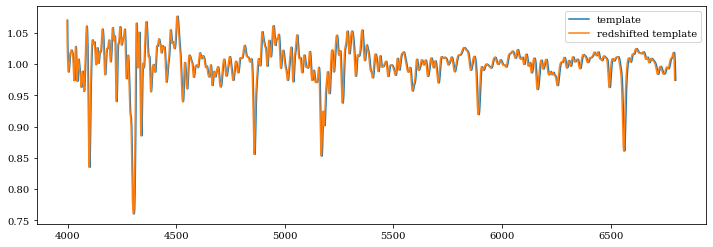

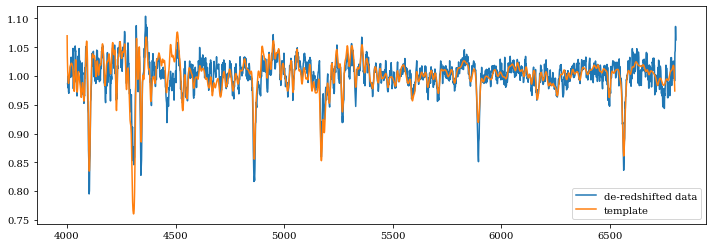

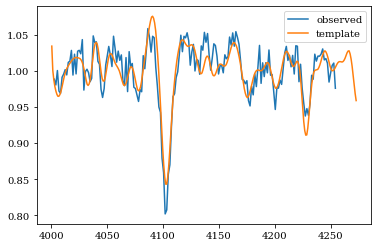

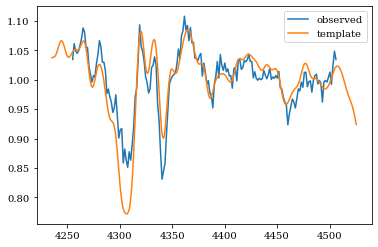

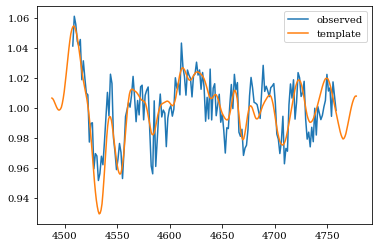

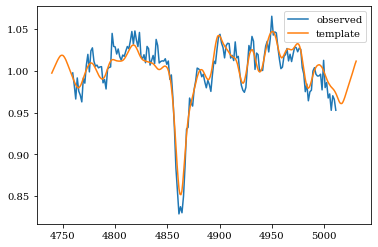

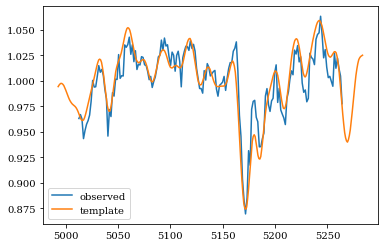

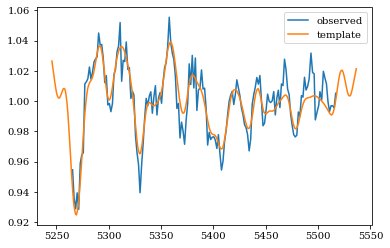

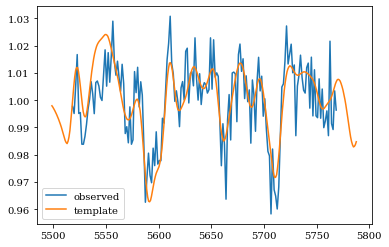

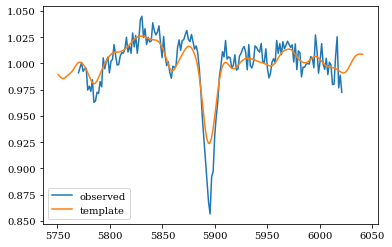

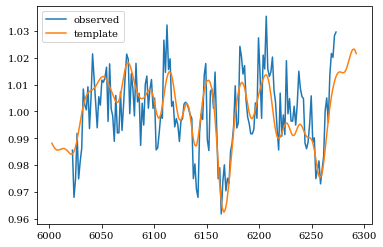

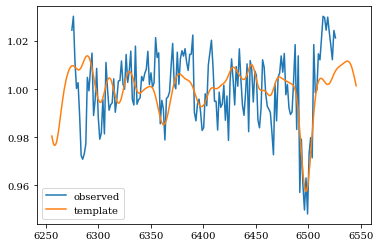

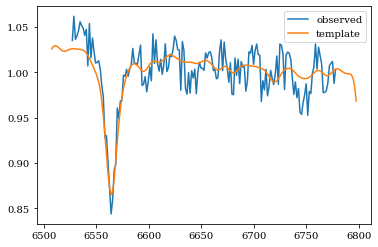

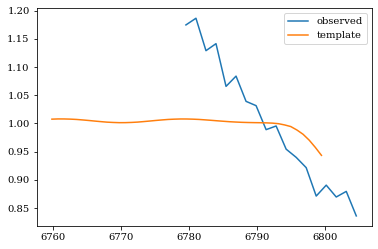

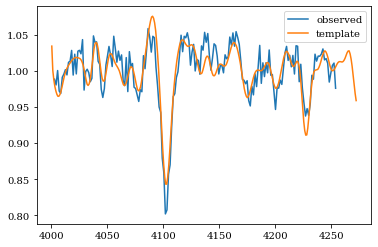

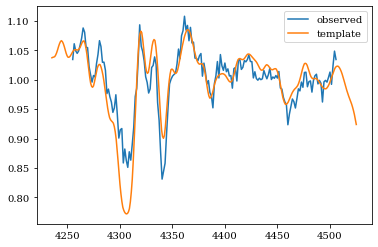

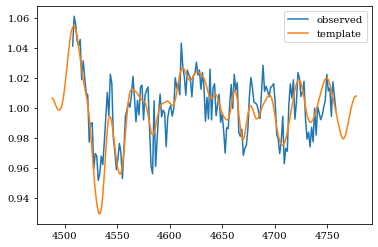

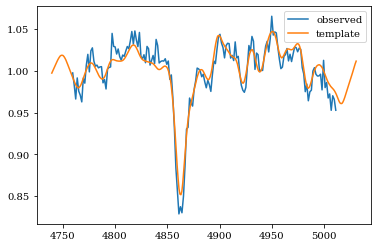

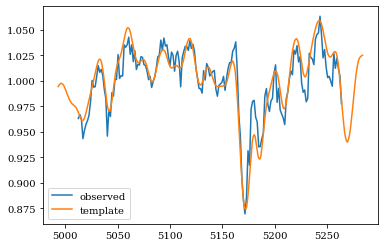

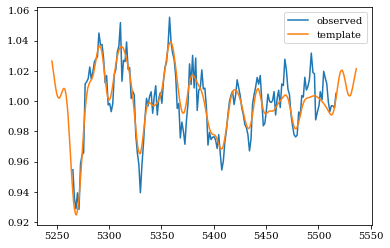

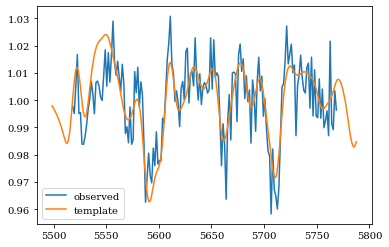

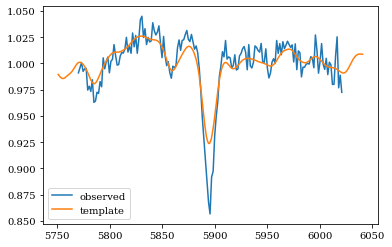

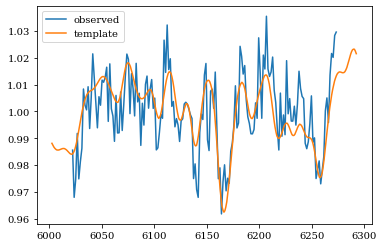

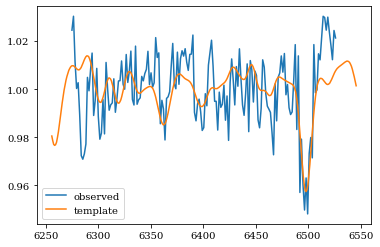

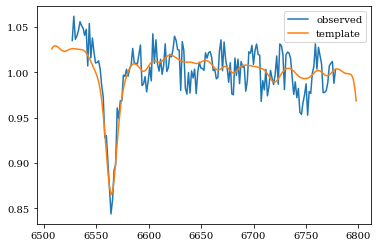

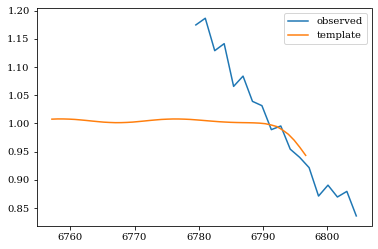

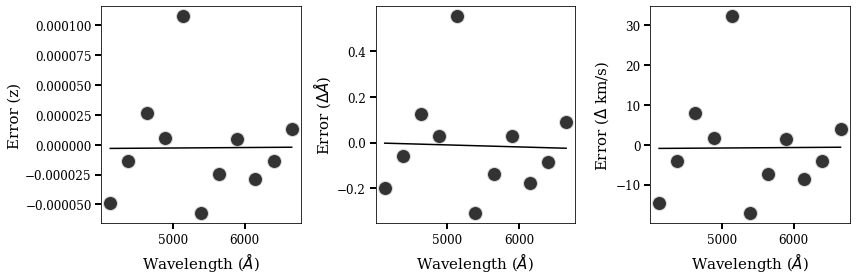

In [13]:
#Re-do redshifting to make sure correction worked
B058_tm_result_corr, B058_dered_wave = dered_corr(B058_noflex_path, B058_template_path, B058_blue_wave_corr, B058_z_lit, 0.005, 'coadd')
print(B058_tm_result_corr[0])
B058_norm_blue_wave_chunks_corr, B058_norm_blue_flux_chunks_corr, B058_norm_blue_noise_chunks_corr = data_chunks(B058_dered_wave, B058_cut_flux, B058_cut_noise, 250)
B058_norm_template_wave_chunks_corr, B058_norm_template_flux_chunks_corr, B058_norm_template_noise_chunks_corr, B058_template_central_wavelengths_corr, \
B058_central_wavelengths_corr = template_chunks(B058_dered_wave, B058_cut_flux, B058_cut_noise, B058_template_path, B058_z_lit, 250, 20, 'after')
QA_chunks(B058_norm_blue_wave_chunks_corr, B058_norm_blue_flux_chunks_corr,B058_norm_template_wave_chunks_corr, B058_norm_template_flux_chunks_corr)
B058_bestfit_redshift_corr, B058_best_chi2_corr, B058_redshifted_spectra_corr, B058_chi2_corr = chunk_redshift(B058_dered_wave, B058_cut_flux, B058_cut_noise, 
                                                                                                               B058_template_path, B058_z_lit, 250, 20, 0, 5e-4, 
                                                                                                               'after')
B058_redshifted_waves_corr = []
B058_redshifted_fluxes_corr = []
for i in range(len(B058_redshifted_spectra_corr)):
    B058_redshifted_waves_corr.append(B058_redshifted_spectra_corr[i].spectral_axis)
    B058_redshifted_fluxes_corr.append(B058_redshifted_spectra_corr[i].flux)
QA_chunks(B058_norm_blue_wave_chunks_corr, B058_norm_blue_flux_chunks_corr, B058_redshifted_waves_corr, B058_redshifted_fluxes_corr)
QA_fit(B058_bestfit_redshift_corr[:-1], B058_central_wavelengths_corr[:-1])
B058_blue_fit_corr, B058_blue_fit_z_corr, B058_blue_fit_kms_corr, B058_blue_error_func_corr, B058_blue_error_func_z_corr, B058_blue_error_func_kms_corr, \
B058_blue_errors_A_corr = fit_errors(B058_bestfit_redshift_corr[:-1], B058_central_wavelengths_corr[:-1])

In [14]:
#Final corrected wavelength
B058_blue_finalcorr_factor, B058_blue_final_corr_wave, B058_final_a, B058_final_b = flexure_function(B058_blue_fit, B058_z_lit, B058_wave_full)

Montonic:  True


## Red

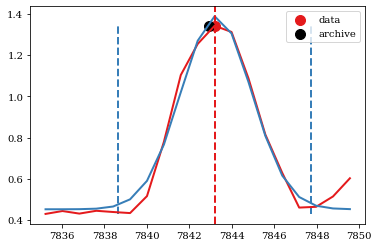

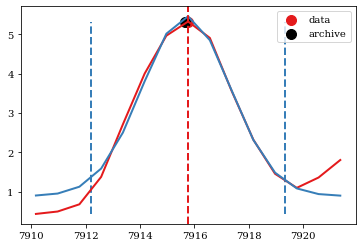

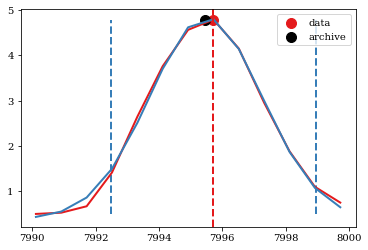

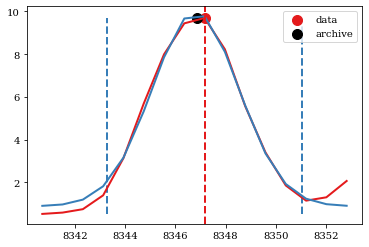

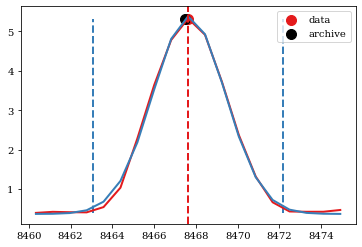

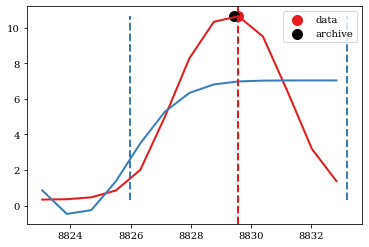

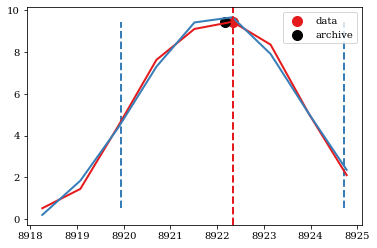

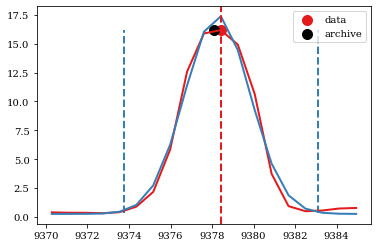

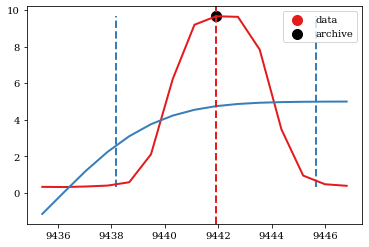

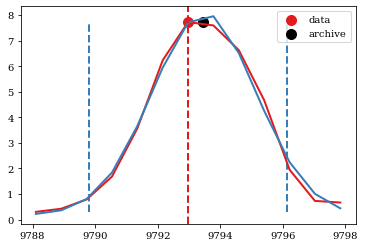

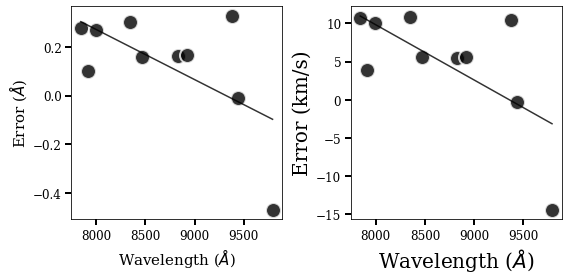

In [15]:
B058_red_file = '/content/gdrive/My Drive/spec1d_r161028_0029-B058-G119_LRISr_20161028T055552.896.fits'
sky_paranal_filename = '/content/gdrive/My Drive/paranal_sky.fits'

B058_waves_1d_red, B058_fluxes_1d_red = read_1dspec(B058_red_file)
sky_paranal_wave, sky_paranal_flux = read_skymod(sky_paranal_filename)

#Smooth the sky model
B058_R_red = data_resolution(sky_paranal_wave, sky_paranal_flux)
B058_smoothed_sky_flux, B058_smoothed_sky_noise = smooth_red(sky_paranal_wave, sky_paranal_flux)

#Find sky centroids 
B058_sky_cents = sky_centroids(sky_paranal_wave, B058_smoothed_sky_flux, B058_smoothed_sky_noise)

#Get offsets between data and model
B058_red_targ_bounds = [[7835, 7850], [7910, 7922], [7990, 8000], [8340, 8353], [8460, 8475], [8823, 8833], [8918, 8925], [9370, 9385], [9435, 9447], [9788, 9798]]
B058_nearest_waves, B058_offsets = centroid_offsets(B058_red_targ_bounds, B058_waves_1d_red, B058_fluxes_1d_red, B058_sky_cents)

#Fit the errors
B058_red_fit, B058_red_fit_kms, B058_red_fit_func, B058_red_fit_func_kms = offset_fit(B058_nearest_waves, B058_offsets)
QA_offset_fit(B058_nearest_waves, B058_offsets)

Monotonic:  True


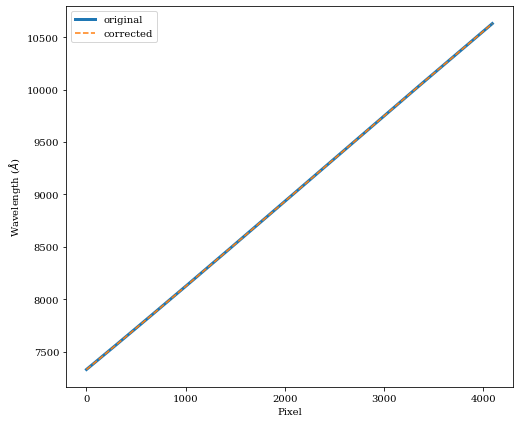

In [16]:
#Import co-added spectra
B058_red_coadd = fits.open('/content/gdrive/My Drive/B058_red_coadd1d.fits')
B058_red_coadd_wave = B058_red_coadd[1].data['wave']
B058_red_coadd_flux = B058_red_coadd[1].data['flux']
B058_red_coadd_noise = 1/np.sqrt(B058_red_coadd[1].data['ivar'])
B058_red_coadd.close()

#Correct the wavelength
B058_red_wave_corr = fit_interp(B058_red_coadd_wave, B058_red_coadd_flux, B058_red_coadd_noise, B058_nearest_waves, 
                                B058_red_fit_func)

Monotonic:  True


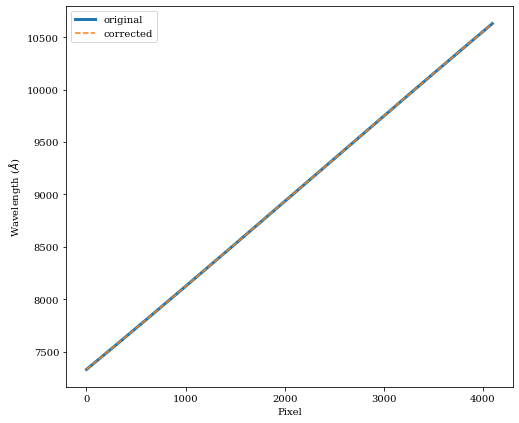

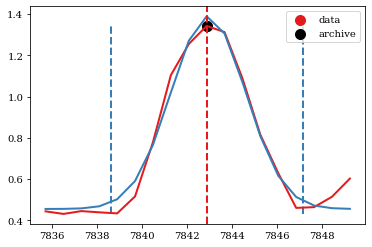

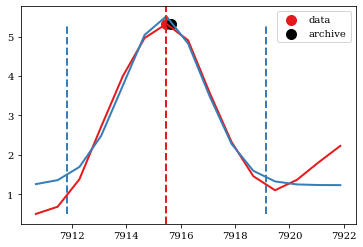

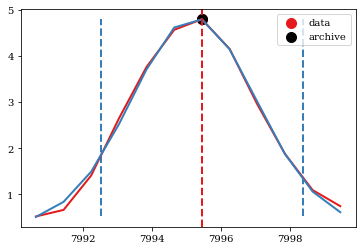

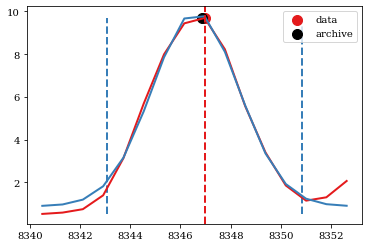

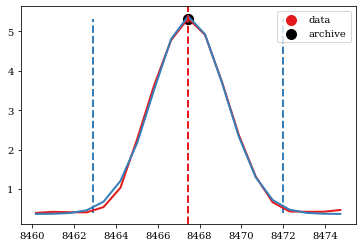

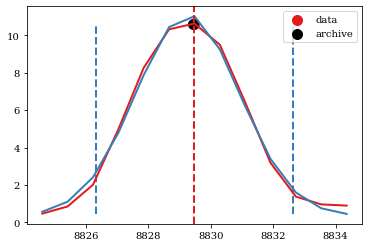

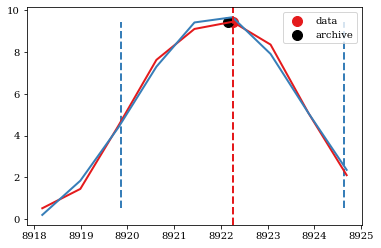

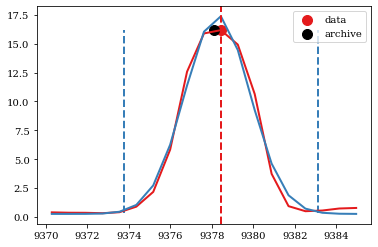

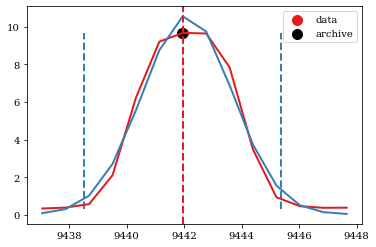

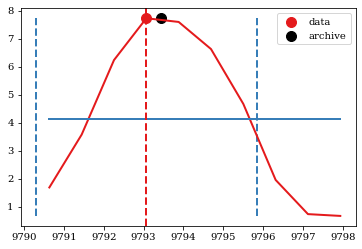

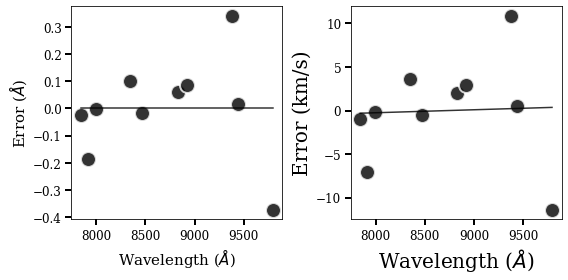

In [17]:
#Re-do to check if correction worked
B058_waves_1d_red_corr = fit_interp(B058_waves_1d_red, B058_fluxes_1d_red, np.zeros_like(B058_fluxes_1d_red), B058_nearest_waves, B058_red_fit_func)

B058_red_targ_bounds_corr = [[7835, 7850], [7910, 7922], [7990, 8000], [8340, 8353], [8460, 8475], [8824, 8835], [8918, 8925], [9370, 9385], [9437, 9448], 
                             [9790, 9798]]
B058_nearest_waves_corr, B058_offsets_corr = centroid_offsets(B058_red_targ_bounds_corr, B058_waves_1d_red_corr, B058_fluxes_1d_red, B058_sky_cents)

B058_red_fit_corr, B058_red_fit_corr_kms, B058_red_fit_func_corr, B058_red_fit_func_corr_kms = offset_fit(B058_nearest_waves_corr, B058_offsets_corr)
QA_offset_fit(B058_nearest_waves_corr, B058_offsets_corr)

False


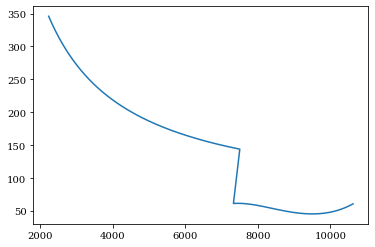

In [18]:
B058_total_corrected_wave = np.concatenate((B058_blue_final_corr_wave, B058_red_wave_corr))
B058_resb, B058_resr = lris_res(B058_blue_final_corr_wave, B058_red_wave_corr)
B058_total_res = np.concatenate((B058_resb, B058_resr))
B058_quad_sum = np.sqrt(23**2 + B058_total_res**2)
print(np.all(B058_quad_sum < 100))
plt.plot(B058_total_corrected_wave, B058_quad_sum)

# Telluric correction

In [19]:
#Wavelength ranges for features to check during telluric correction
feature_6300_range = [5800, 6700]
feature_8200_range = [8000, 8400]
feature_9700_range = [9600, 9900]
correction_range = [9320, 9380]

Text(0.5, 0, 'Wavelength ($\\AA$)')

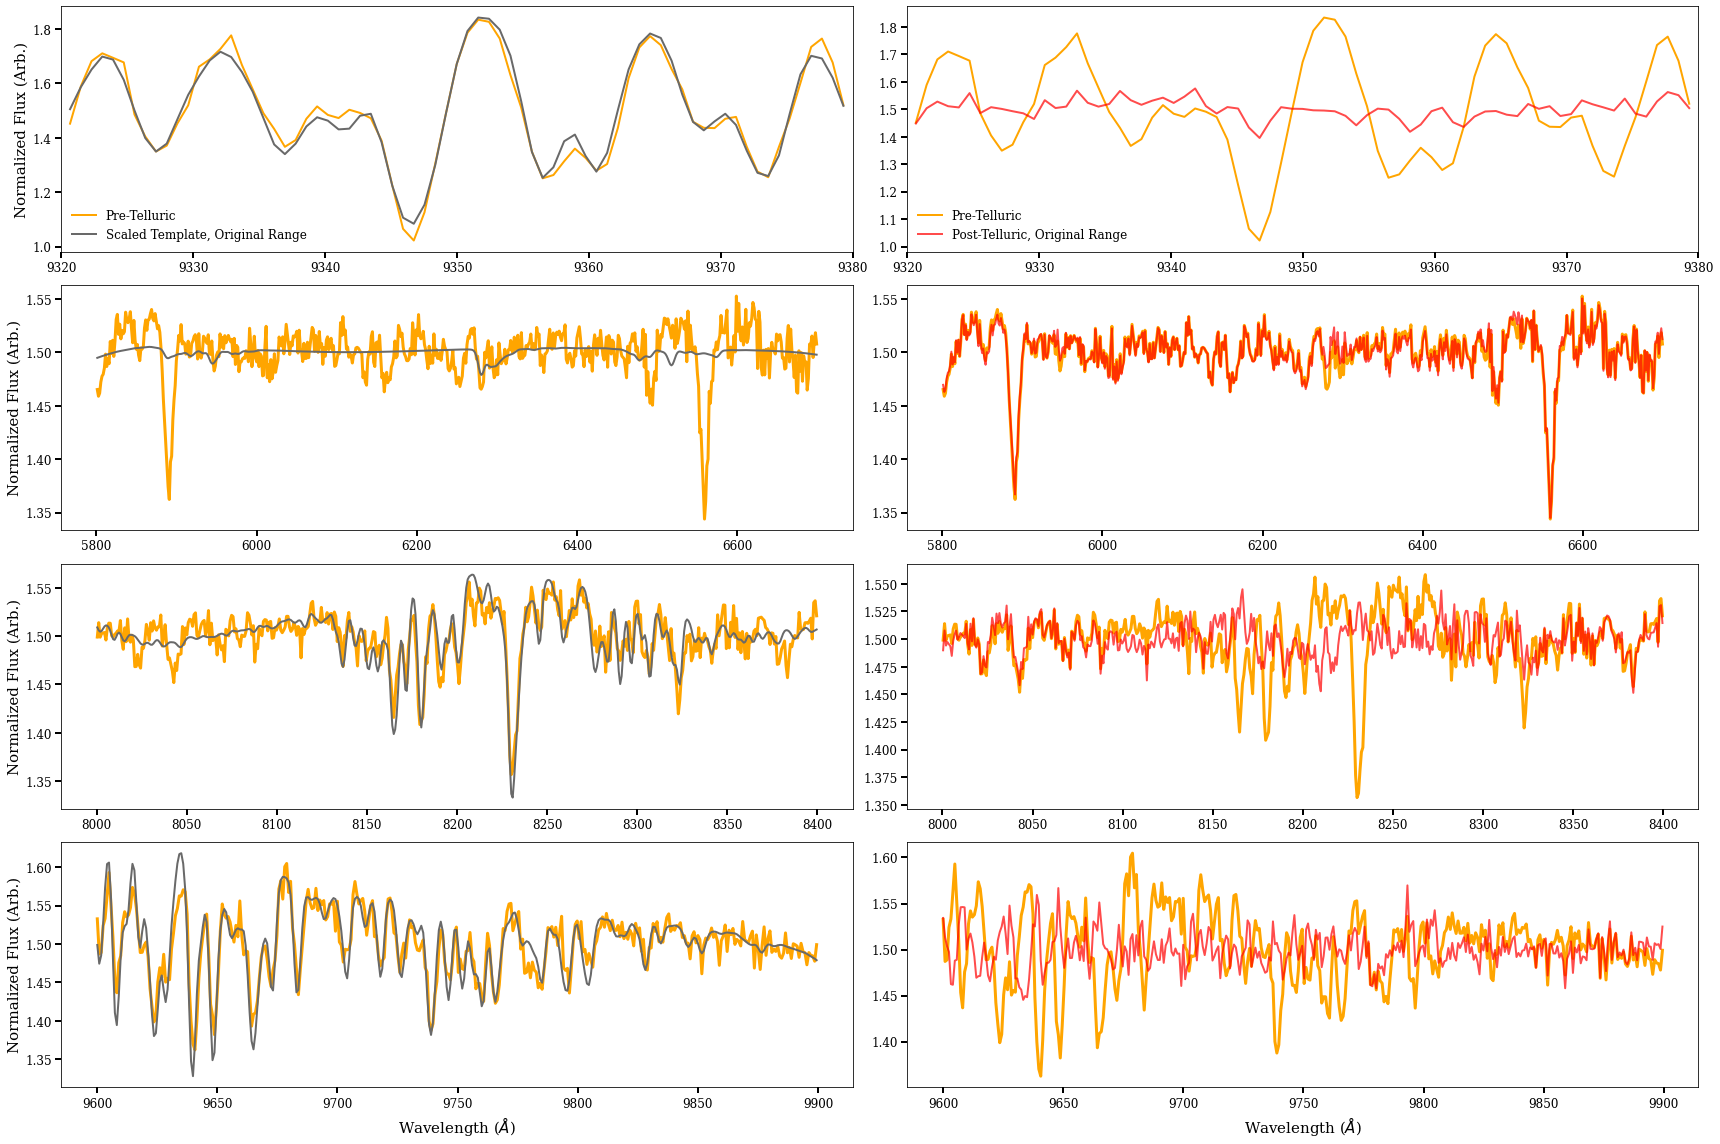

In [20]:
#Telluric correction
B058_blue_path = '/content/gdrive/My Drive/B058_noflex_blue_coadd1d.fits'
B058_red_path = '/content/gdrive/My Drive/B058_red_coadd1d.fits'
B058_tell_flux, B058_tell_wave, B058_scaled_template, B058_targ_flux = telluric_correction_routine(B058_blue_path, B058_red_path, B058_blue_final_corr_wave, 
                                                                                                   B058_red_wave_corr)
B058_total_corrected_wave = np.concatenate((B058_blue_final_corr_wave, B058_red_wave_corr))
B058_total_noise = np.concatenate((1/np.sqrt(B058_noise_full), B058_red_coadd_noise))

#Check telluric corrections
#Pre-telluric correction
norm_wave_B058_raw_correction, norm_flux_B058_raw_correction, noise = continuum_normalize(correction_range[0], 
                                                                         correction_range[-1], B058_targ_flux, 
                                                                         B058_total_corrected_wave, B058_total_noise)
norm_wave_B058_raw_6300, norm_flux_B058_raw_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                         feature_6300_range[-1], B058_targ_flux, 
                                                                         B058_total_corrected_wave, B058_total_noise)
norm_wave_B058_raw_8200, norm_flux_B058_raw_8200, noise = continuum_normalize(feature_8200_range[0], 
                                                                         feature_8200_range[-1], B058_targ_flux, 
                                                                         B058_total_corrected_wave, B058_total_noise)
norm_wave_B058_raw_9700, norm_flux_B058_raw_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                         feature_9700_range[-1], B058_targ_flux, 
                                                                         B058_total_corrected_wave, B058_total_noise)

#Post-telluric correction
norm_wave_B058_tell_correction, norm_flux_B058_tell_correction, noise = continuum_normalize(correction_range[0], 
                                                                         correction_range[-1], B058_tell_flux, 
                                                                         B058_tell_wave, B058_total_noise)
norm_wave_B058_tell_6300, norm_flux_B058_tell_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                         feature_6300_range[-1], B058_tell_flux, 
                                                                         B058_tell_wave, B058_total_noise)
norm_wave_B058_tell_8200, norm_flux_B058_tell_8200, noise = continuum_normalize(feature_8200_range[0], 
                                                                         feature_8200_range[-1], B058_tell_flux, 
                                                                         B058_tell_wave, B058_total_noise)
norm_wave_B058_tell_9700, norm_flux_B058_tell_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                         feature_9700_range[-1], B058_tell_flux, 
                                                                         B058_tell_wave, B058_total_noise)

#Scaled templates
norm_wave_B058_scale_correction, norm_flux_B058_scale_correction, noise = continuum_normalize(correction_range[0], 
                                                                         correction_range[-1], B058_scaled_template, 
                                                                         B058_tell_wave, B058_total_noise)
norm_wave_B058_scale_6300, norm_flux_B058_scale_6300, noise = continuum_normalize(feature_6300_range[0], 
                                                                         feature_6300_range[-1], 
                                                                               B058_scaled_template, 
                                                                               B058_tell_wave, B058_total_noise)
norm_wave_B058_scale_8200, norm_flux_B058_scale_8200, noise = continuum_normalize(feature_8200_range[0], 
                                                                         feature_8200_range[-1], 
                                                                               B058_scaled_template,
                                                                               B058_tell_wave, B058_total_noise)
norm_wave_B058_scale_9700, norm_flux_B058_scale_9700, noise = continuum_normalize(feature_9700_range[0], 
                                                                         feature_9700_range[-1], 
                                                                               B058_scaled_template,
                                                                               B058_tell_wave, B058_total_noise)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(24, 16))
fig.set_tight_layout(True)
ax[0,0].plot(norm_wave_B058_raw_correction, norm_flux_B058_raw_correction+0.5, color='orange', lw=2, label='Pre-Telluric')
ax[0,0].plot(norm_wave_B058_scale_correction, norm_flux_B058_scale_correction+0.5, color='dimgrey', lw=2, label='Scaled Template, Original Range')
ax[0,0].tick_params(length=6, width=2, labelsize=12)
ax[0,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[0,0].legend(fontsize=12, framealpha=0)
ax[0,0].set_xlim(9320, 9380)

ax[1,0].plot(norm_wave_B058_raw_6300, norm_flux_B058_raw_6300+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[1,0].plot(norm_wave_B058_scale_6300, norm_flux_B058_scale_6300+0.5, color='dimgrey', lw=2,  label='Scaled Template')
ax[1,0].tick_params(length=6, width=2, labelsize=12)
ax[1,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[2,0].plot(norm_wave_B058_raw_8200, norm_flux_B058_raw_8200+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[2,0].plot(norm_wave_B058_scale_8200, norm_flux_B058_scale_8200+0.5, color='dimgrey', lw=2, label='Scaled Template')
ax[2,0].tick_params(length=6, width=2, labelsize=12)
ax[2,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)

ax[3,0].plot(norm_wave_B058_raw_9700, norm_flux_B058_raw_9700+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[3,0].plot(norm_wave_B058_scale_9700, norm_flux_B058_scale_9700+0.5, color='dimgrey', lw=2, label='Scaled Template')
ax[3,0].tick_params(length=6, width=2, labelsize=12)
ax[3,0].set_ylabel('Normalized Flux (Arb.)', fontsize=15)
ax[3,0].set_xlabel('Wavelength ($\AA$)', fontsize=15)

ax[0,1].plot(norm_wave_B058_raw_correction, norm_flux_B058_raw_correction+0.5, color='orange', lw=2, label='Pre-Telluric')
ax[0,1].plot(norm_wave_B058_tell_correction, norm_flux_B058_tell_correction+0.5, color='r', alpha=0.7, lw=2, label='Post-Telluric, Original Range')
ax[0,1].tick_params(length=6, width=2, labelsize=12)
ax[0,1].legend(fontsize=12, framealpha=0)
ax[0,1].set_xlim(9320, 9380)

ax[1,1].plot(norm_wave_B058_raw_6300, norm_flux_B058_raw_6300+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[1,1].plot(norm_wave_B058_tell_6300, norm_flux_B058_tell_6300+0.5, color='r', alpha=0.7, lw=2)
ax[1,1].tick_params(length=6, width=2, labelsize=12)

ax[2,1].plot(norm_wave_B058_raw_8200, norm_flux_B058_raw_8200+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[2,1].plot(norm_wave_B058_tell_8200, norm_flux_B058_tell_8200+0.5, color='r', alpha=0.7, lw=2)
ax[2,1].tick_params(length=6, width=2, labelsize=12)

ax[3,1].plot(norm_wave_B058_raw_9700, norm_flux_B058_raw_9700+0.5, color='orange', lw=3, label='Pre-Telluric')
ax[3,1].plot(norm_wave_B058_tell_9700, norm_flux_B058_tell_9700+0.5, color='r', alpha=0.7, lw=2)
ax[3,1].tick_params(length=6, width=2, labelsize=12)
ax[3,1].set_xlabel('Wavelength ($\AA$)', fontsize=15)

# Smoothing

In [21]:
#Smoothing functions
def spikes(wave, flux, hi, lo, mid, mid2):
    '''Return indices where large telluric spikes/artifacts are.

    Parameters
    ----------
    wave : tuple
      Wavelength array
    flux : tuple
      Flux array
    hi : float
      Threshold for how high spikes need to be in order to mask them
    lo : float
      Threshold for how low spikes need to be in order ot mask them
    mid : float
      Threshold for spikes from telluric correction (where the blue and red side join)
    mid2 : float
      Sometimes need another threshold for telluric spikes <= 7500A

    Returns
    -------
    spikes_hi : tuple
      Positions of spikes above hi threshold
    spikes_lo : tuple
      Positions of spikes below lo threshold
    spikes_mid : tuple
      Positions of spikes above mid threshold
    spikes_mid2 : tuple
      Positions of spikes above mid2 threshold
    '''

    spikes_hi = np.argwhere(flux > hi)
    spikes_lo = np.argwhere(flux < lo)

    #Get mid-spectra spikes
    inds = []
    for i in range(len(flux)):
        if wave[i] >= 7500 and wave[i] <= 8000:
            inds.append(i)
            
    inds2 = []
    for i in range(len(flux)):
        if wave[i] >= 6800 and wave[i] <= 7500:
            inds2.append(i)

    spikes_mid = []
    for i in range(len(flux[inds])):
        if flux[inds][i] >= mid:
            spikes_mid.append(inds[i])
    
    spikes_mid2 = []
    for i in range(len(flux[inds2])):
        if flux[inds2][i] >= mid2:
            spikes_mid2.append(inds2[i])

    return spikes_hi, spikes_lo, spikes_mid, spikes_mid2

#######################
#Modified Prospector smoothspec functions (added correct noise smoothing)
def mask_wave(wavelength, width=1, wlo=0, whi=np.inf, outwave=None,
              nsigma_pad=20.0, linear=False, **extras):
    """Restrict wavelength range (for speed) but include some padding based on
    the desired resolution.
    """
    # Base wavelength limits
    if outwave is not None:
        wlim = np.array([outwave.min(), outwave.max()])
    else:
        wlim = np.squeeze(np.array([wlo, whi]))
    # Pad by nsigma * sigma_wave
    if linear:
        wlim += nsigma_pad * width * np.array([-1, 1])
    else:
        wlim *= (1 + nsigma_pad / width * np.array([-1, 1]))
    mask = (wavelength > wlim[0]) & (wavelength < wlim[1])
    return mask

def smooth_fft(dx, spec, sigma):
    """Basic math for FFT convolution with a gaussian kernel.
    :param dx:
        The wavelength or velocity spacing, same units as sigma
    :param sigma:
        The width of the gaussian kernel, same units as dx
    :param spec:
        The spectrum flux vector
    """
    # The Fourier coordinate
    ss = rfftfreq(len(spec), d=dx)
    # Make the fourier space taper; just the analytical fft of a gaussian
    taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (ss ** 2))
    ss[0] = 0.01  # hack
    # Fourier transform the spectrum
    spec_ff = np.fft.rfft(spec)
    # Multiply in fourier space
    ff_tapered = spec_ff * taper
    # Fourier transform back
    spec_conv = np.fft.irfft(ff_tapered)
    return spec_conv

def smooth_fft_noise(dx, spec, sigma):
    """Basic math for FFT convolution with a gaussian kernel.
    :param dx:
        The wavelength or velocity spacing, same units as sigma
    :param sigma:
        The width of the gaussian kernel, same units as dx
    :param spec:
        The spectrum flux vector
    """
    # The Fourier coordinate
    ss = rfftfreq(len(spec), d=dx)
    # Make the fourier space taper; just the analytical fft of a gaussian
    taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (ss ** 2))
    ss[0] = 0.01  # hack
    # Fourier transform the spectrum
    spec_ff = np.fft.rfft(spec)
    # Multiply in fourier space
    ff_tapered = spec_ff * taper**2
    # Fourier transform back
    spec_conv = np.fft.irfft(ff_tapered)
    return spec_conv

def smooth_lsf_fft(wave, spec, unc, outwave, b, sigma=None, lsf=None, pix_per_sigma=2,
                   eps=0.25, preserve_all_input_frequencies=False, corr=False, **kwargs):
    """Smooth a spectrum by a wavelength dependent line-spread function, using
    FFTs.
    :param wave:
        Wavelength vector of the input spectrum.
    :param spectrum:
        Flux vector of the input spectrum.
    :param unc:
        Uncertainty vector of the input spectrum.
    :param outwave:
        Desired output wavelength vector.
    :param sigma: (optional)
        Dispersion (in same units as ``wave``) as a function `wave`.  ndarray
        of same length as ``wave``.  If not given, sigma will be computed from
        the function provided by the ``lsf`` keyword.
    :param lsf: (optional)
        Function used to calculate the dispersion as a function of wavelength.
        Must be able to take as an argument the ``wave`` vector and any extra
        keyword arguments and return the dispersion (in the same units as the
        input wavelength vector) at every value of ``wave``.  If not provided
        then ``sigma`` must be specified.
    :param pix_per_sigma: (optional, default: 2)
        Number of pixels per sigma of the smoothed spectrum to use in
        intermediate interpolation and FFT steps. Increasing this number will
        increase the accuracy of the output (to a point), and the run-time, by
        preserving all high-frequency information in the input spectrum.
    :param preserve_all_input_frequencies: (default: False)
        This is a switch to use a very dense sampling of the input spectrum
        that preserves all input frequencies.  It can significantly increase
        the call time for often modest gains...
    :param eps: (optional)
        Deprecated.
    :param corr: (default: False)
        Indicates whether the data is correlated or not.  Default is 
        uncorrelated.  If the data is uncorrelated, the variance of the 
        convolved data is found by convolving the variance of the data with the
        square of the kernel used to convolve the data.  If the data is correlated, 
        the variance of the convolved data is found by convolving the variance of 
        the data with the square of the Gaussian kernel, but scaled with a factor
        depending on the widths of the Gaussian kernel and width of the Gaussian 
        coefficient in the covariance.  Uncertainty propagation method from 
        R. Klein 2021.
    :param **kwargs:
        All additional keywords are passed to the function supplied to the
        ``lsf`` keyword, if present.
    :returns flux:
        The input spectrum smoothed by the wavelength dependent line-spread
        function.  Same length as ``outwave``.
    """
    # This is sigma vs lambda
    if sigma is None:
        sigma = lsf(wave, **kwargs)

    # Now we need the CDF of 1/sigma, which provides the relationship between x and lambda
    # does dw go in numerator or denominator?
    # I think numerator but should be tested
    dw = np.gradient(wave)
    cdf = np.cumsum(dw / sigma)
    cdf /= cdf.max()

    # Now we create an evenly sampled grid in the x coordinate on the interval [0,1]
    # and convert that to lambda using the cdf.
    # This should result in some power of two x points, for FFT efficiency

    # Furthermore, the number of points should be high enough that the
    # resolution is critically sampled.  And we want to know what the
    # resolution is in this new coordinate.
    # There are two possible ways to do this

    # 1) Choose a point ~halfway in the spectrum
    # half = len(wave) / 2
    # Now get the x coordinates of a point eps*sigma redder and bluer
    # wave_eps = eps * np.array([-1, 1]) * sigma[halpha]
    # x_h_eps = np.interp(wave[half] + wave_eps, wave, cdf)
    # Take the differences to get dx and dsigma and ratio to get x per sigma
    # x_per_sigma = np.diff(x_h_eps) / (2.0 * eps) #x_h_epsilon - x_h

    # 2) Get for all points (slower?):
    sigma_per_pixel = (dw / sigma)
    x_per_pixel = np.gradient(cdf)
    x_per_sigma = np.nanmedian(x_per_pixel / sigma_per_pixel)
    N = pix_per_sigma / x_per_sigma

    # Alternatively, just use the smallest dx of the input, divided by two for safety
    # Assumes the input spectrum is critically sampled.
    # And does not actually give x_per_sigma, so that has to be determined anyway
    if preserve_all_input_frequencies:
        # preserve more information in the input spectrum, even when way higher
        # frequency than the resolution of the output.  Leads to slightly more
        # accurate output, but with a substantial time hit
        N = max(N, 1.0 / np.nanmin(x_per_pixel))

    # Now find the smallest power of two that divides the interval (0, 1) into
    # segments that are smaller than dx
    nx = int(2**np.ceil(np.log2(N)))

    # now evenly sample in the x coordinate
    x = np.linspace(0, 1, nx)
    dx = 1.0 / nx

    # And now we get the spectrum at the lambda coordinates of the even grid in x
    lam = np.interp(x, cdf, wave)
    newspec = np.interp(lam, wave, spec)
    newunc = np.interp(lam, wave, unc)

    # And now we convolve.
    # If we did not know sigma in terms of x we could estimate it here
    # from the resulting sigma(lamda(x)) / dlambda(x):
    # dlam = np.gradient(lam)
    # sigma_x = np.median(lsf(lam, **kwargs) / dlam)
    # But the following just uses the fact that we know x_per_sigma (duh).
    spec_conv = smooth_fft(dx, newspec, x_per_sigma)
    
    #If the data is correlated
    if corr:
        theta = x_per_sigma #width of the d-dimensional Gaussian kernel (should be the same as sigma fed to smooth_fft?)
        b = b #width of the Gaussian coefficient in the covariance??? Set to be some number close to 1 for now
        d = len(x) #d-dimensional Gaussian (number of points)
        unc_conv = ((2*np.sqrt(pi)*theta*b)/np.sqrt(theta**2 + b**2))**d*smooth_fft_noise(dx, newunc, x_per_sigma)
    #If the data is uncorrelated
    else:
        unc_conv = smooth_fft_noise(dx, newunc, x_per_sigma)

    # and interpolate back to the output wavelength grid.
    smooth_spec = np.interp(outwave, lam, spec_conv)
    smooth_unc = np.interp(outwave, lam, unc_conv)
    
    return smooth_spec, smooth_unc

def smoothspec(wave, spec, unc, b, resolution=None, outwave=None,
               smoothtype="vel", fftsmooth=True,
               min_wave_smooth=0, max_wave_smooth=np.inf, corr=False, **kwargs):
    """
    Parameters
    ----------
    wave : ndarray of shape ``(N_pix,)``
        The wavelength vector of the input spectrum.  Assumed Angstroms.
    spec : ndarray of shape ``(N_pix,)``
        The flux vector of the input spectrum.
    unc : ndarray of shape ``(N_pix,)``
        The uncertainty vector of the input spectrum.  Assumed variance.
    resolution : float
        The smoothing parameter.  Units depend on ``smoothtype``.
    outwave : ``None`` or ndarray of shape ``(N_pix_out,)``
        The output wavelength vector.  If ``None`` then the input wavelength
        vector will be assumed, though if ``min_wave_smooth`` or
        ``max_wave_smooth`` are also specified, then the output spectrum may
        have different length than ``spec`` or ``wave``, or the convolution may
        be strange outside of ``min_wave_smooth`` and ``max_wave_smooth``.
        Basically, always set ``outwave`` to be safe.
    smoothtype : string, optional, default: "vel"
        The type of smoothing to perform.  One of:
        + ``"vel"`` - velocity smoothing, ``resolution`` units are in km/s
          (dispersion not FWHM)
        + ``"R"`` - resolution smoothing, ``resolution`` is in units of
          :math:`\lambda/ \sigma_\lambda` (where :math:`\sigma_\lambda` is
          dispersion, not FWHM)
        + ``"lambda"`` - wavelength smoothing.  ``resolution`` is in units of
          Angstroms
        + ``"lsf"`` - line-spread function.  Use an aribitrary line spread
          function, which can be given as a vector the same length as ``wave``
          that gives the dispersion (in AA) at each wavelength.  Alternatively,
          if ``resolution`` is ``None`` then a line-spread function must be
          present as an additional ``lsf`` keyword.  In this case all additional
          keywords as well as the ``wave`` vector will be passed to this ``lsf``
          function.
    fftsmooth : bool, optional, default: True
        Switch to use FFTs to do the smoothing, usually resulting in massive
        speedups of all algorithms.  However, edge effects may be present.
    min_wave_smooth : float, optional default: 0
        The minimum wavelength of the input vector to consider when smoothing
        the spectrum.  If ``None`` then it is determined from the output
        wavelength vector and padded by some multiple of the desired resolution.
    max_wave_smooth : float, optional, default: inf
        The maximum wavelength of the input vector to consider when smoothing
        the spectrum.  If None then it is determined from the output wavelength
        vector and padded by some multiple of the desired resolution.
    inres : float, optional
        If given, this parameter specifies the resolution of the input.  This
        resolution is subtracted in quadrature from the target output resolution
        before the kernel is formed.
        In certain cases this can be used to properly switch from resolution
        that is constant in velocity to one that is constant in wavelength,
        taking into account the wavelength dependence of the input resolution
        when defined in terms of lambda.  This is possible iff:
        * ``fftsmooth`` is False
        * ``smoothtype`` is ``"lambda"``
        * The optional ``in_vel`` parameter is supplied and True.
        The units of ``inres`` should be the same as the units of
        ``resolution``, except in the case of switching from velocity to
        wavelength resolution, in which case the units of ``inres`` should be
        in units of lambda/sigma_lambda.
    in_vel : float (optional)
        If supplied and True, the ``inres`` parameter is assumed to be in units
        of lambda/sigma_lambda. This parameter is ignored **unless** the
        ``smoothtype`` is ``"lambda"`` and ``fftsmooth`` is False.
    Returns
    -------
    flux : ndarray of shape ``(N_pix_out,)``
        The smoothed spectrum on the `outwave` grid, ndarray.
    """
    if smoothtype == 'vel':
        linear = False
        units = 'km/s'
        sigma = resolution
        fwhm = sigma * sigma_to_fwhm
        Rsigma = ckms / sigma
        R = ckms / fwhm
        width = Rsigma
        assert np.size(sigma) == 1, "`resolution` must be scalar for `smoothtype`='vel'"

    elif smoothtype == 'R':
        linear = False
        units = 'km/s'
        Rsigma = resolution
        sigma = ckms / Rsigma
        fwhm = sigma * sigma_to_fwhm
        R = ckms / fwhm
        width = Rsigma
        assert np.size(sigma) == 1, "`resolution` must be scalar for `smoothtype`='R'"
        # convert inres from Rsigma to sigma (km/s)
        try:
            kwargs['inres'] = ckms / kwargs['inres']
        except(KeyError):
            pass

    elif smoothtype == 'lambda':
        linear = True
        units = 'AA'
        sigma = resolution
        fwhm = sigma * sigma_to_fwhm
        Rsigma = None
        R = None
        width = sigma
        assert np.size(sigma) == 1, "`resolution` must be scalar for `smoothtype`='lambda'"

    elif smoothtype == 'lsf':
        linear = True
        width = 100
        sigma = resolution

    else:
        raise ValueError("smoothtype {} is not valid".format(smoothtype))

    # Mask the input spectrum depending on outwave or the wave_smooth kwargs
    mask = mask_wave(wave, width=width, outwave=outwave, linear=linear,
                     wlo=min_wave_smooth, whi=max_wave_smooth, **kwargs)
    w = wave[mask]
    s = spec[mask]
    u = unc[mask]
    if outwave is None:
        outwave = wave

    # Choose the smoothing method
    if smoothtype == 'lsf':
        if fftsmooth:
            smooth_method = smooth_lsf_fft
            if sigma is not None:
                # mask the resolution vector
                sigma = resolution[mask]
        else:
            smooth_method = smooth_lsf
            if sigma is not None:
                # convert to resolution on the output wavelength grid
                sigma = np.interp(outwave, wave, resolution)
    elif linear:
        if fftsmooth:
            smooth_method = smooth_wave_fft
        else:
            smooth_method = smooth_wave
    else:
        if fftsmooth:
            smooth_method = smooth_vel_fft
        else:
            smooth_method = smooth_vel

    # Actually do the smoothing and return
    smooth_spec, smooth_unc = smooth_method(w, s, u, outwave, b, sigma, corr, **kwargs)
    return smooth_spec, smooth_unc
#####################

def smooth_chunk(wave, flux, noise, res, spike_vals, literature_sigma, smooth_value, b, corr, smooth_type):
    """Return smoothed spectra, where regions of large telluric spikes have been interpolated over.
    Smooth in chunks defined outside of the function (so you can smooth blue and red separately)

    Parameters
    ----------
    wave : tuple
      Wavelength array
    flux : tuple
      Tellurically-corrected flux
    noise : tuple
      Uncertainty array 
    res : tuple
      Wavelength-dependent instrumental resolution from Keck
    spike_vals : tuple
      Spike threshold values to mask
    literature_sigma : float
      Velocity dispersion from the literature
    smooth_value : float
      Value to smooth by/to
    b : float
      For correlated noise, not relevant anymore (only use uncorrelated version)
    corr : bool
      True if noise is correlated, False if uncorrelated
    smooth_type : str
      'by' or 'to 

    Returns
    -------
    wave : tuple
      Wavelength array
    smoothed_flux : tuple
      Final, smoothed flux, to be fit with alf
    np.sqrt(smoothed_noise) : tuple
      Smoothed noise
    bad_pixels : tuple
      List of pixels being interpolated over
    flux_cut : tuple
      Flux array where we've removed regions < 4000A and around 6300A.  For testing. 
    res : tuple
      Wavelength-dependent LRIS resolution
    """

    flux_cut = np.copy(flux)
    
    #Get pixel positions of noisy telluric spikes
    hi, lo, mid, mid2 = spike_vals
    spikes_hi, spikes_lo, spikes_mid, spikes_mid2 = spikes(wave, flux, hi, lo, mid, mid2)
    bad_pixels = []
    for i in range(len(spikes_hi)):
        for j in range(len(spikes_hi[i])):
            bad_pixels.append(spikes_hi[i][j])
    for i in range(len(spikes_lo)):
        for j in range(len(spikes_lo[i])):
            bad_pixels.append(spikes_lo[i][j])
    for i in range(len(spikes_mid)):
        bad_pixels.append(spikes_mid[i])
    for i in range(len(spikes_mid2)):
        bad_pixels.append(spikes_mid2[i])

    bad_pixels = np.sort(list(set(bad_pixels))) #Remove duplicates
    
    #Interpolate over noisy spikes
    if len(bad_pixels) != 0:
        flux[bad_pixels] = np.nan
        noise[bad_pixels] = np.nan

    kernel = Gaussian1DKernel(stddev = 1)
    intp_flux = interpolate_replace_nans(flux, kernel, convolve = convolve_fft)
    intp_noise = interpolate_replace_nans(noise, kernel, convolve = convolve_fft)

    #Smooth to smooth_value
    c = 299792.458 #speed of light
    if smooth_type == 'to':
        sigma_aa_desired = smooth_value/c*wave #Convert to Angstroms
        sigma_aa_original = np.sqrt(res**2 + literature_sigma**2)/c*wave #Effective resolution converted to Angstroms
        delta_sigma_aa_vector = np.sqrt(sigma_aa_desired**2 - sigma_aa_original**2)
        plt.plot(wave, sigma_aa_desired**2 - sigma_aa_original**2)
    elif smooth_type == 'by':
        sigma_aa_desired = smooth_value/c*wave
        delta_sigma_aa_vector = sigma_aa_desired
        plt.plot(wave, sigma_aa_desired)
    
    smoothed_flux, smoothed_noise = smoothspec(wave, intp_flux, intp_noise, outwave=wave, b=1.05, smoothtype='lsf', 
                                               resolution=delta_sigma_aa_vector, fftsmooth=True, corr=corr)
    
    return wave, smoothed_flux, np.sqrt(smoothed_noise), bad_pixels, flux_cut, res

In [22]:
#Import co-added target spectra
blue_coadd1d = fits.open(B058_blue_path)
blue_dat = blue_coadd1d[1].data
blue_coadd1d.close()

red_coadd1d = fits.open(B058_red_path)
red_dat = red_coadd1d[1].data
red_coadd1d.close()

#Get wavelengths and fluxes
blue_dat_wave, red_dat_wave = B058_blue_final_corr_wave, B058_red_wave_corr
blue_wave = blue_dat_wave[(blue_dat_wave >= 4000)]
blue_ivar = blue_dat['ivar'][(blue_dat_wave >= 4000)]
red_wave = red_dat_wave
red_ivar = red_dat['ivar']
total_dat_wave = np.concatenate((blue_wave, red_wave))

tell_wave, tell_flux = B058_tell_wave, B058_tell_flux
#Chunk the spectra
fluxb = np.copy(tell_flux)[(tell_wave >= 4000) & (tell_wave <= np.max(blue_wave))]
fluxr = np.copy(tell_flux)[(tell_wave >= np.min(red_wave)) & (tell_wave <= np.max(red_wave))]
waveb = np.copy(tell_wave)[(tell_wave >= 4000) & (tell_wave <= np.max(blue_wave))]
waver = np.copy(tell_wave)[(tell_wave >= np.min(red_wave)) & (tell_wave <= np.max(red_wave))]
noiseb = 1/(np.concatenate((blue_ivar, red_ivar))[(total_dat_wave >= 4000) & (total_dat_wave <= np.max(blue_wave))])
noiser = 1/(np.concatenate((blue_ivar, red_ivar))[(total_dat_wave >= np.min(red_wave)) & \
                                                         (total_dat_wave <= np.max(red_wave))])

#Get resolution
resb, resr = lris_res(waveb, waver)

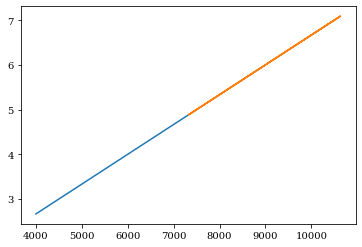

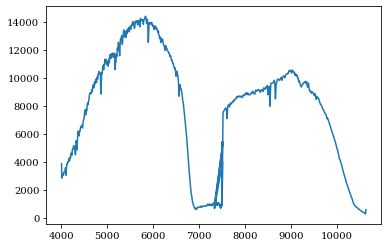

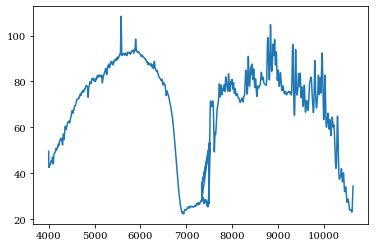

In [25]:
#Smooth the spectrum 
b_by200_smooth_wave_uncorr, b_by200_smooth_flux_uncorr, b_by200_smooth_noise_uncorr, b_by200_smooth_bad_uncorr, \
b_by200_flux_cut_uncorr, b_by200_total_res_uncorr = smooth_chunk(waveb, fluxb, noiseb, resb, 
                                                                       [30000, 0, 30000, 12000], 23, 200, 1.05, False, 'by')

r_by200_smooth_wave_uncorr, r_by200_smooth_flux_uncorr, r_by200_smooth_noise_uncorr, r_by200_smooth_bad_uncorr, \
r_by200_flux_cut_uncorr, r_by200_total_res_uncorr = smooth_chunk(waver, fluxr, noiser, resr, 
                                                                 [30000, 0, 30000, 12000], 23, 200, 1.05, False, 'by')

br_by200_smooth_wave_uncorr = np.concatenate((b_by200_smooth_wave_uncorr, r_by200_smooth_wave_uncorr))
br_by200_smooth_flux_uncorr = np.concatenate((b_by200_smooth_flux_uncorr, r_by200_smooth_flux_uncorr))
br_by200_smooth_noise_uncorr = np.concatenate((b_by200_smooth_noise_uncorr, r_by200_smooth_noise_uncorr))

plt.figure()
plt.plot(br_by200_smooth_wave_uncorr, br_by200_smooth_flux_uncorr)
plt.figure()
plt.plot(br_by200_smooth_wave_uncorr, br_by200_smooth_noise_uncorr)

In [26]:
#Write .dat file
br_by200_weight_col_uncorr = np.ones(len(br_by200_smooth_wave_uncorr))
br_by200_resolution_uncorr = np.concatenate((b_by200_total_res_uncorr, r_by200_total_res_uncorr))

br_by200_df_uncorr = pd.DataFrame(np.array((br_by200_smooth_wave_uncorr, br_by200_smooth_flux_uncorr, br_by200_smooth_noise_uncorr, 
                            br_by200_weight_col_uncorr, br_by200_resolution_uncorr)).T)
#br_by200_df_uncorr.to_csv('br_by200/B058_new_br_by200.dat', index=False, sep='\t')

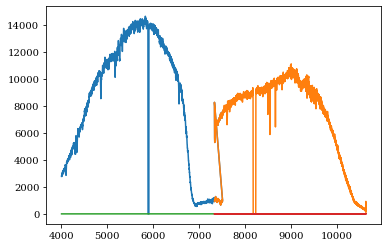

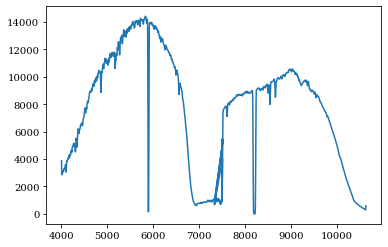

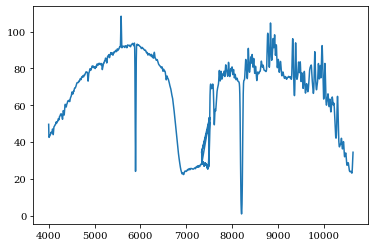

In [27]:
#If you want to mask out the Na features
#Mask out Na features
NaD = [5876.875, 5909.375]
NaI = [8168.500, 8234.125]

#Get pixels where Na features are
NaD_inds = []
for i in range(len(fluxb)):
    if waveb[i] >= NaD[0] and waveb[i] <= NaD[-1]:
        NaD_inds.append(i)

NaI_inds = []
for i in range(len(fluxr)):
    if waver[i] >= NaI[0] and waver[i] <= NaI[-1]:
        NaI_inds.append(i)

#Interpolate over
fluxb_NaD = np.copy(fluxb)
fluxb_NaD[NaD_inds] = np.nan
noiseb_NaD = np.copy(noiseb)
noiseb_NaD[NaD_inds] = np.nan

fluxr_NaI = np.copy(fluxr)
fluxr_NaI[NaI_inds] = np.nan
noiser_NaI = np.copy(noiser)
noiser_NaI[NaI_inds] = np.nan

kernel = Gaussian1DKernel(stddev = 1)
intp_fluxb_NaD = interpolate_replace_nans(fluxb_NaD, kernel, convolve = convolve_fft)
intp_noiseb_NaD = interpolate_replace_nans(noiseb_NaD, kernel, convolve = convolve_fft)

intp_fluxr_NaI = interpolate_replace_nans(fluxr_NaI, kernel, convolve = convolve_fft)
intp_noiser_NaI = interpolate_replace_nans(noiser_NaI, kernel, convolve = convolve_fft)

plt.plot(waveb, intp_fluxb_NaD)
plt.plot(waver, intp_fluxr_NaI)

#Smooth
b_by200_Na_smooth_wave_uncorr, b_by200_Na_smooth_flux_uncorr, b_by200_Na_smooth_noise_uncorr, b_by200_Na_smooth_bad_uncorr, \
b_by200_Na_flux_cut_uncorr, b_by200_Na_total_res_uncorr = smooth_chunk(waveb, intp_fluxb_NaD, intp_noiseb_NaD, resb, 
                                                                       [30000, 0, 30000, 12000], 23, 200, 1.05, False, 'by')

r_by200_Na_smooth_wave_uncorr, r_by200_Na_smooth_flux_uncorr, r_by200_Na_smooth_noise_uncorr, r_by200_Na_smooth_bad_uncorr, \
r_by200_Na_flux_cut_uncorr, r_by200_Na_total_res_uncorr = smooth_chunk(waver, intp_fluxr_NaI, intp_noiser_NaI, resr, 
                                                                 [30000, 0, 30000, 12000], 23, 200, 1.05, False, 'by')

br_by200_Na_smooth_wave_uncorr = np.concatenate((b_by200_Na_smooth_wave_uncorr, r_by200_Na_smooth_wave_uncorr))
br_by200_Na_smooth_flux_uncorr = np.concatenate((b_by200_Na_smooth_flux_uncorr, r_by200_Na_smooth_flux_uncorr))
br_by200_Na_smooth_noise_uncorr = np.concatenate((b_by200_Na_smooth_noise_uncorr, r_by200_Na_smooth_noise_uncorr))

plt.figure()
plt.plot(br_by200_Na_smooth_wave_uncorr, br_by200_Na_smooth_flux_uncorr)
plt.figure()
plt.plot(br_by200_Na_smooth_wave_uncorr, br_by200_Na_smooth_noise_uncorr)

#Write .dat file
br_by200_Na_weight_col_uncorr = np.ones(len(br_by200_Na_smooth_wave_uncorr))
br_by200_Na_resolution_uncorr = np.concatenate((b_by200_Na_total_res_uncorr, r_by200_Na_total_res_uncorr))

br_by200_Na_df_uncorr = pd.DataFrame(np.array((br_by200_Na_smooth_wave_uncorr, br_by200_Na_smooth_flux_uncorr, br_by200_Na_smooth_noise_uncorr, 
                            br_by200_Na_weight_col_uncorr, br_by200_Na_resolution_uncorr)).T)
# br_by200_Na_df_uncorr.to_csv('thesis_data/B058_new_br_by200_NaD_NaI.dat', index=False, sep='\t')